Importando librerias

In [1]:
import os
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
# import datetime
# from datetime import datetime,timedelta
import shapefile

from datetime import date

import pandas as pd
import csv
import datetime
import glob
import operator
import socket
import sys
import time
import skimage
 
import numpy as np
import numpy.ma as ma

from scipy import ndimage
from skimage import measure

from skimage.measure import regionprops
from skimage.measure import find_contours
from skimage.feature import peak_local_max
from skimage.segmentation import random_walker
from skimage.morphology import skeletonize

Rutas de acceso

In [10]:
#ruta de acceso a carpeta con valores de IVT
pwd_ivt    = 'C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/IVT_CH_PMP'

#ruta de acceso a archivo excel con valores de precipitacion de 25 tormentas. Lee el archivo CSV rain
pwd_rain = 'C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/rain.csv'

#ruta de acceso a la carpeta con las coordenadas 
pwd_coords = pwd_ivt + '/coords/'     

#ruta de acceso a la carpeta output donde se almacenan los resultados
pwd_save = 'C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/output/'


Funcion days and month
Entrega el N° de dias que tiene el mes month del año year

In [11]:
def days_in_month(year,month):  #Funcion que entrega el numero de dias del mes month

    if month in ['01','03','05','07','08','10','12']: #si el mes month es 01(ene), 03(mar), 05(may), 
                                                    #07(jul), 08(ago), 10(oct), 12(dic), entonces la funcion return 31 dias
        return 31
    elif month == '02': #si el mes es 02(feb),entonces se pregunta si el año es bisiesto mediante la 
                        #funcion operator.mod que calcula el residuo de la division del año year transformado 
                        #a entero (int(year)) entre 4. Si el residuo es 0 entonces el año es divisible
                        #por 4 y entonces es bisiesto y la funcion return 29 dias. else return 28 dias
        
        if operator.mod(int(year),4) == 0:
            return 29
        else:
            return 28
    elif month in ['04','06','09','11']:  #si el mes month es 04(abr), 06(jun), 09(sep), 11(nov), 
                                            #entonces la funcion return 30 dias        
        return 30

Funcion Skeleton. Entrega la longitud en km de un array (imagen?) meidante la esqueletizacion

In [12]:
def skeleton_length(array):    #comentado linea 13, 24, 30, 35 y 1088 de main program para no mostrar grafico skeleton
    
#la funcion skeletonize se utiliza para procesamiento de imagenes
#skeletonize encuentra los pixeles centrales de los objetos en la imagen array y los conecta para formar una linea delgada
#(skeletonizacion) que representa la forma basica del objeto

    sk = skeletonize(array)   # works by making successive passes of the image. On each pass, border pixels are identified and removed on the condition that they do not break the connectivity of the corresponding object.
    
#subplot muestra 1 fila y 2 columas, es decir 2 areas de trabajo o graficos (2 subplots)
#sharex y sharey =True implica que en las 2 secciones o areas de trabajo se utilizan los mismos ejes x e y
#figsize entrega el tamaño de la figura en pulgadas (8 plg de ancho y 4 plg de alto)
    # display results
    #fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),sharex=True, sharey=True)

#transforma axes a 1 dimension mediante el comando ravel, para asi trabajar con cada subplot
#utilizando solo un indice, es decir, ax[0] es el primer subplot y ax[1] el segundo subplot)
    ax = axes.ravel()
    
    #imshow muestra la imagen array en el primer subplot ax[0]
    #con cmap se define la paleta de colores que se utilizara para mostrar la imagen array  
    # plt.cm.gray es la escala de grises
    
    #ax[0].imshow(array, cmap=plt.cm.gray)
    
    ax[0].axis('off')  #comando para ocultar los ejes
    ax[0].set_title('original', fontsize=20) #titulo para el plot
    
    
    #ax[1].imshow(sk, cmap=plt.cm.gray)     #se muestra la imagen esqueletizada sk
    ax[1].axis('off')
    ax[1].set_title('skeleton', fontsize=20)    #tamaño de fuente=20
    
    fig.tight_layout()     #funcion que ajusta los espacios entre subplots para que no se superpongan los titulos 
    #plt.show()             #funcion que muestra la figura en una ventana

    ir,ic = np.nonzero(sk) #devuelve las posiciones de los elementos distintos de 0 contenidos en el array sk
                            #ir e ic son las posiciones de las filas y  columnas respectivamente de pixeles 
                            #con valor distinto de 0
                            #entonces, la funcion entrega las coordenadas de los elementos no cero, es decir,
                            #los pixeles con valor distinto de 0 de la imagen sk (recordar que sk esta esqueletizada)
    
    numri = np.max(ir) - np.min(ir)       #resta de coordenada maxima y minima en la fila?
    numci = np.max(ic) - np.min(ic)       #resta de coordenada maxy minima en la columna?
                                          #se utiliza para calcular el tamaño (alto y ancho) de la imagen
#DUDA    
    if numri*1/2. > numci*1/2.:            #POR QUE 1/2?
        arr_flag = 'vert'                   #si la dimension numri (referido a fila, entonces vertical) es mayor a la
                                            #dimension de numci (referido a columna, entonces horizontal), entonces 
                                            #se define arr_flag como vert, de lo contrario se define como horiz
    else:
        arr_flag = 'horiz'
        

    newr,newc = [],[]                  #listas vacias que se llenan con coordenadas duplicadas de filas (newr) y col (newc)
    
    if arr_flag == 'horiz':
        duplicates = []
        for ind,col in enumerate(ic):  #enumerate asigna el indice y valor a cada elemento de ic 
                                        #ind guarda el indice (posicion) del valor col de ic 
                                        #ic son las columnas de los pixeles con valores distintos de 0 en la imagen sk
            
            if np.count_nonzero(np.where(ic == ic[ind])) > 1 and col not in duplicates:  #se buscan elementos duplicados en la 
                                                                                          #lista ic
                                                               #np.where(ic==ic[ind]) entrega una lista con los indices  
                                                               #(posicion dentro de ic) de los elementos ic[ind]
                                                               #Luego count_nonzero cuenta la cantidad de elementos con valor
                                                               #distinto de cero dentro de la lista
                                                               #si hay mas de uno, entonces existen duplicados y si                                                                         
                duplicates.append(col)                         #el valor no esta en la lista duplicados se agrega su valor col
                
                newc.append(ic[ind])                           #se agregan las coordenadas ic[ind] de las columnas con valores     
                                                               #duplicadas a la lista newc      
                
                newr.append(np.min(ir[np.where(ic == ic[ind])]))   #np.where() entrega los indices (posicion dentro de ic) de 
                                                                   #los valores duplicados
                                                                    #Luego se agrega el valor minimo de esta lista de indices
                                                                    #a la lista newr
#DUDA                
            elif col in duplicates:                          #si col (valores de ic) esta en duplicados, es decir, ya se
                continue                                     #agrego a newc y newr? entonces con continue se sale del ciclo
            else:                                            #y se continua con la siguiente iteracion
                newr.append(ir[ind])                         #sino, se agregan las coordenadas ir[ind] e ic[ind] a newr y newc
                newc.append(ic[ind])                          #respectivamente
            
        snewr, snewc = (list(el) for el in zip(*sorted(zip(newr, newc))))    #zip  toma newr y newc y los combina para generar
                                                                        #una lista de pares de coordenadas tipo (fila,columna)
                                                                        #sorted ordena los pares anteriores de la lista en 
                                                                    #orden ascendente (menor a mayor) considerando
                                                                    #el primer elemento de cada par en la lista, es decir,
                                                                    # considerando los valores de newr (filas)    
#DUDA                                                               #* para que?
                                                                    #la variable el recorre el objeto zip(*sorted(zip())) pero
                                                                    #para utilizarlo se debe convertir a lista y esto se hace
                                                                    #con el list(el)
                                                        #finalmente snewr y snewc son 2 listas nuevas que contiene los valores
                                                        #ordenados de newr y newc. Estas 2 listas se corresponden entre si,
                                                        #es decir, snewr[0] se corresponde con snewc[0] y asi...
                                                #por lo tanto, se crean 2 listas snewr y snewc ordenadas ascedentemente y 
                                                #correspondidas entre si
        
        z = np.polyfit(snewc,snewr,3)       #se ajusta un polinomio de grado 3 a las coordenadas snewc y snewr
                                            #Z es una lista con el valor de los coeficientes 
        
        
        
        p = np.poly1d(z)                     #poly1d(z) crea el polinomio p(z)
                                                #por lo tanto ahora se puede acceder al polinomio como p(z=valor)
        x = np.arange(np.min(snewc),np.max(snewc)+1,1)   #np.arange() devuelve una lista con valores secuenciales de 
                                                            #1 en 1 que van desde el valor minimo de snewc al valor 
                                                            #maximo de snewc+1, osea
                                                    #x=[min(snewc),min(snewc)+1,min(snewc)+2]
        
        

#DUDA
        y = p(x)                                             #se evalua el polinomio p(z) con los valores de x
        # y = np.where(y >= bounds[3], bounds[3]-0.1, y)     #que es bounds? 
        y = np.where(y <= bounds[3],  y, bounds[3]-0.1,)     #si y <= a bounds[3] entonces y toma el valor y, sino
                                                            #se le asigna el valor bounds[3]-0.1
                                                            #se establece un limite inferior a los valores de y
        
    if arr_flag == 'vert':
        duplicates = []                                                       #ind guarda el indice (posicion) del 
                                                                                    #valor row de ir
        for ind,row in enumerate(ir):                                         #ir son las filas de los pixeles con 
                                                                                #valores distintos de 0 en la imagen sk
             
                
           if np.count_nonzero(np.where(ir == ir[ind])) > 1 and row not in duplicates:
               duplicates.append(row)
               newr.append(ir[ind])
               newc.append(np.min(ic[np.where(ir == ir[ind])]))                  #analogo a las columnas, aca se buscan
                                                                                #los valores duplicados de ir (filas de los
                                                                                #pixeles con valores distintos de 0 en la
                                                                                #imagen sk)
           elif row in duplicates:
               continue
           else:
               newr.append(ir[ind])
               newc.append(ic[ind])
        snewr, snewc = (list(el) for el in zip(*sorted(zip(newr, newc))))      #snewr y snewc son 2 listas nuevas que 
                                                                            #contiene los valores ordenados de newr y newc.
                                                    #Estas 2 listas se corresponden entre si, es decir, snewr[0] se 
                                                    #corresponde con snewc[0] y asi...
                                                #por lo tanto, se crean 2 listas snewr y snewc ordenadas ascedentemente y 
                                                #correspondidas entre si
        z = np.polyfit(snewr,snewc,3)           #se ajusta  polinomio de grado 3 a las coordenadas snewr y snewc 
        p = np.poly1d(z)                         #p(z)
        y = np.arange(np.min(snewr),np.max(snewr)+1,1)    #lista con valores secuenciales de 1 en 1 desde min(snewr) 
                                                            #a max(snewr)+1
        
        # y = np.where(y >= bounds[3], bounds[3]-0.1, y)       #limite superior para y menor a [3]
        y = np.where(y <= bounds[3],  y, bounds[3]-0.1,)       #limite inferior mayor a bounds[3]
        x = p(y)                                               
        
        
        
    # HACER QUE LOS sub_lats SEAN CONGRUENTES CON lat2D
        
    y_vals = np.copy(y)                                               #se copian los valores de y en la variable y_vals
    y_pixel_km = (1./2)*(111.2) # Approx. pixel extent in km          #tamaño en km de cada pixel en la imagen
    piecewise_length = []                                           #111.2 es la aproximacion de 1 grado de longitud, osea,
                                                                    #40075(circunferencia de la tierra)/360°

    for i in range(0,len(x)-1,1):                                              #se calcula la longitud total del objeto en
                                                                                #la imagen
            
        # Visiting Pythagoras to estimate length of skeleton in km
        x_pixel_km = (1./2)*(np.pi/180.0)*6378.137*abs(np.cos((np.pi/180.0)*sub_lats[int(y_vals[i])]))
        
        len_km = np.sqrt((abs(y_vals[i+1]-y_vals[i])*x_pixel_km)**2+(abs(x[i+1]-x[i])*y_pixel_km)**2)
        piecewise_length.append(len_km)
        
    print('****  total lenght = ', int(np.sum(piecewise_length)), ' [km]' , '\n')
        
        
  
    return x,y,int(np.sum(piecewise_length))

Funcion retrieve. Entrega matriz de IVT cada 6 horas transformando la longitud a 30° a 390°

In [13]:
def retrieve_data(date_str,hr_ind):
                                                                            #date_str es la fecha y hr_ind es la hora?
    raw_array = np.load(outpath+data_str+'_IVT_6hly_'+date_str+'.npy')     #se carga el archivo _IVT_6hly_ ubicado en
                                                                            #outpath, se le agregan nombres y queda como
                                                                            #data_str_IVT-6hly_date_str
    
    # Transforming the array's grid from -180 > 180 to 30 > 390 
    data_array = np.empty([361, 540])                                #matriz vacia de 361 filas y 540 columnas
    data_array[:,0:225] = raw_array[hr_ind,:,315:541]           #raw_array[] entrega la matriz hr_ind1 con las filas
                                                                #desde la 0 a la 315 y columnas desde 315 a 540
                                                                #lo anterior se guarda en data_array en las filas 
                                                                #desde la 0 a la ultima y en las columnas de la 0 a la 224
                                                                
    data_array[:,225:541] = raw_array[hr_ind,:,0:315]         #se saca la matriz de la hora hr_ind con todas las filas y 
                                                        #las columnas desde la 0 a la 314 y se asigna a data array en la
                                                            #posicion: todas las filas y desde la columna 225 a la 540
    
    return data_array                               #se devuelve la nueva matriz con los datos de IVT (latitud y longitud)
                                                    # en un formato de tamaño 361x540 con la fecha date_str y hora hr_ind
                                                    #que se quiere


Control de variables (se definen valores)

In [14]:
# Setting Output and Control Variables
# ----------------------------------------------------------

save_csv          = True             # Optional saving of AR characteristics in CSV file    #variable para decidir si las caracteristicas AR se guardan en formato CSV
                                                                                        
save_ar_ivt       = True             # Optional saving of arrays of IVT anom. w/in ARs    

wind_based_orient = False        # Correct the feature orientation based on LL winds?       #corregir la orientacion de las caracteristicas en funcion de los  
                                                                                                #vientos de baja altura 

data_str      = 'JM_test'              # for file naming                                    #para nombrar archivos

method_str    = 'FFT3_79-14S'      # to retrieve correct seasonal cycle of IVT file         #para recuperar el ciclo estacional
                                                                                            #correcto del archivo IVT
                                                                                            #a method_str se le asigna ese nombre porque
                                                                                            #se usa el metodo FFT3 (transformada rapida de fourier)
                                                                                            #para procesar los datos en la region que va desde los
                                                                                            #79°S hasta los 14°S

# bounds        = (67., 5., 252., 118.) # As: N, S, E, W                                    #coordenadas para Asia
bounds        = (-999., -999, -999, -120) # As: N, S, E, W                                  #limites geograficos 

#DUDA
region_str    = 'NPAC' # for file naming                                                    #para nombrar los archivos de salida. NPAC pacifico norte?




Procesando datos de tormenta (archivo CSV rain)

Error: Host not found
Executing on host LAPTOP-J9U5T7J6 

Analizando el año: 2000
Analizando el mes: ['06']
Analizando el dia ['12']
Analizando la hora 00
Working on: 2000 / 06 / 12 / 00 



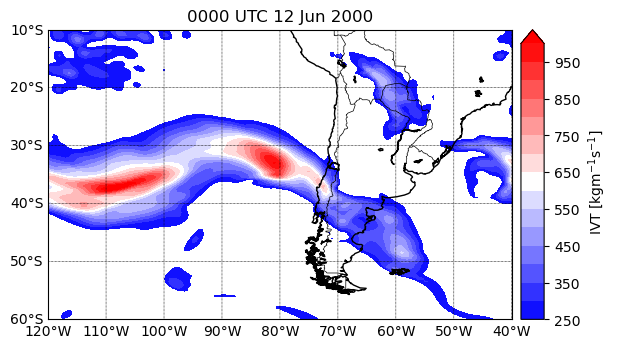

MIN IVT = 250


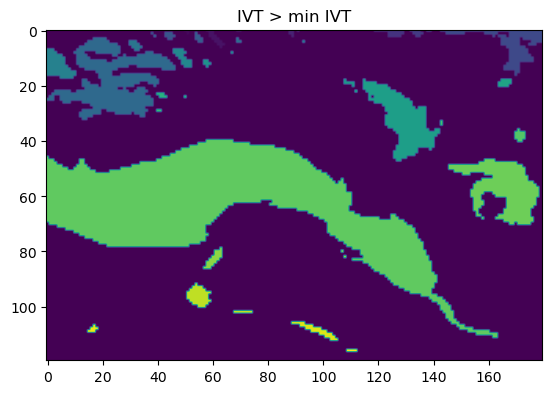

Minimum blob size = 200


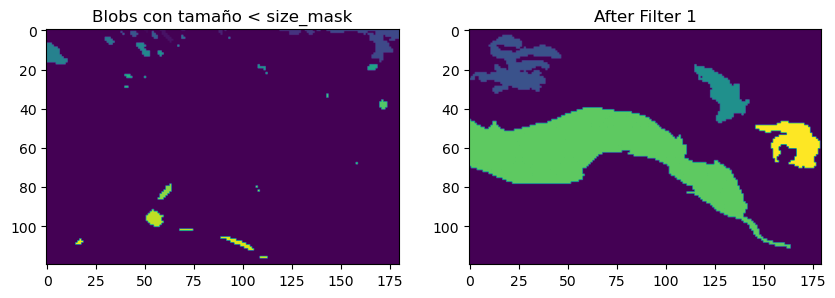

Minimum aspect = 1.6
Minimum length = 25
El blob eliminado tiene relacion de aspecto de 1.29 y largo 38.31 pixeles


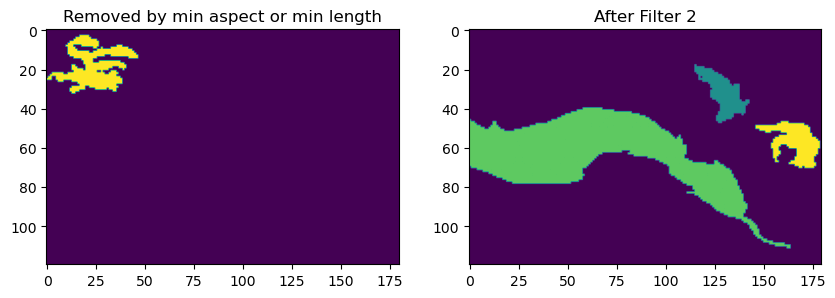

Minimum orientation = 0.95
El blob eliminado tiene orientacion 0.64


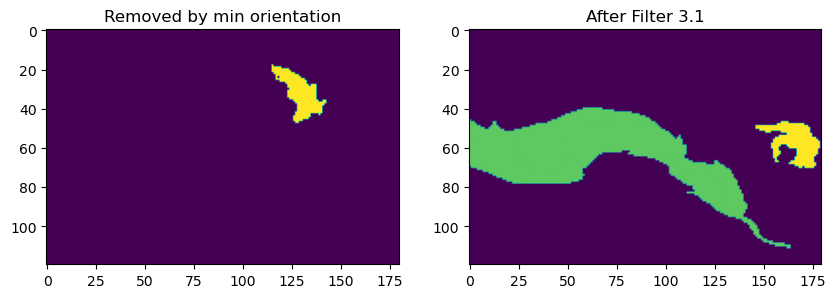

Minimum aspect = 1.6
Minimum length = 25
El blob eliminado tiene relacion de aspecto de 1.58 y largo 32.74 pixeles


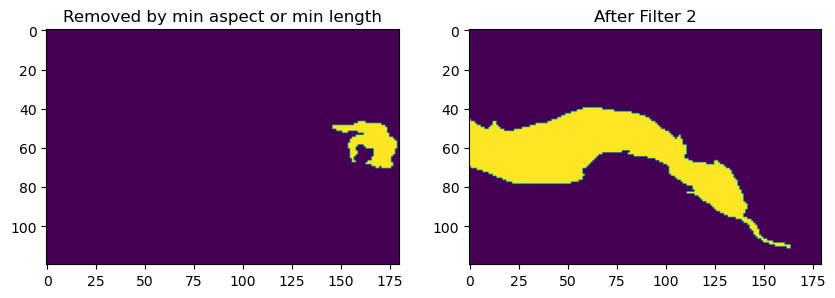

el valor de ii es: 0


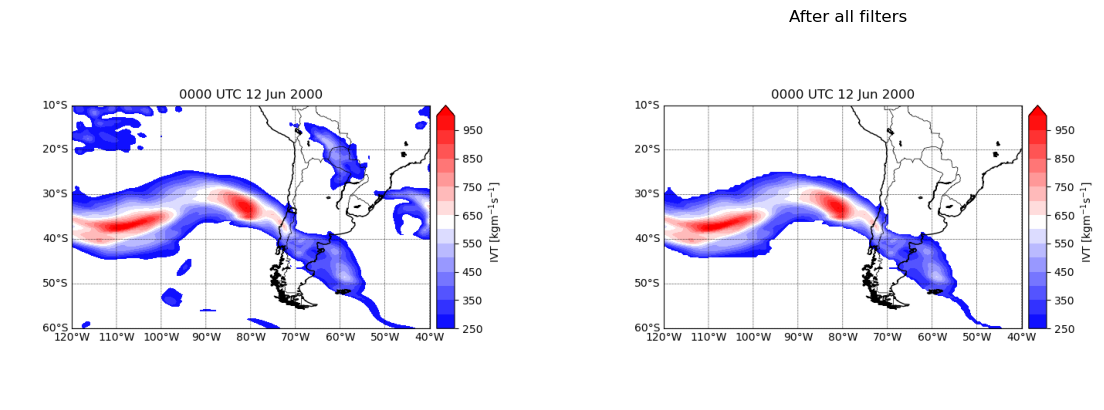

Analizando la hora 06
Working on: 2000 / 06 / 12 / 06 



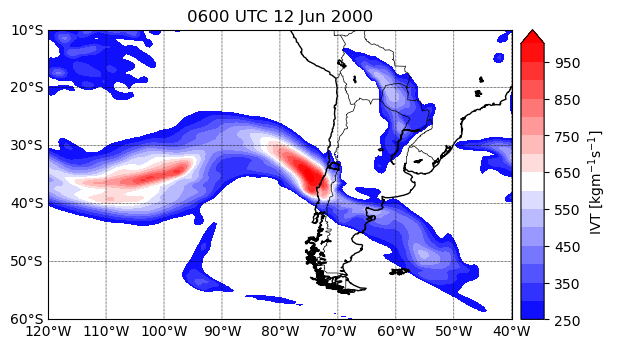

MIN IVT = 250


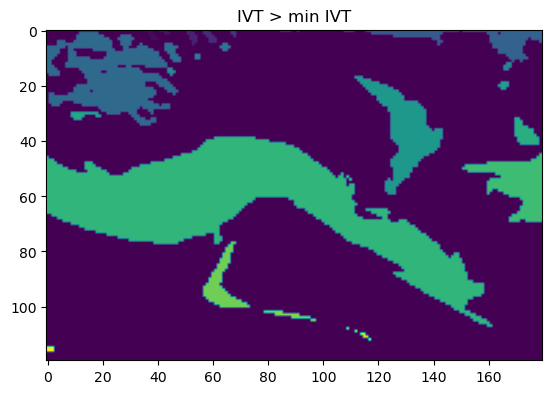

Minimum blob size = 200


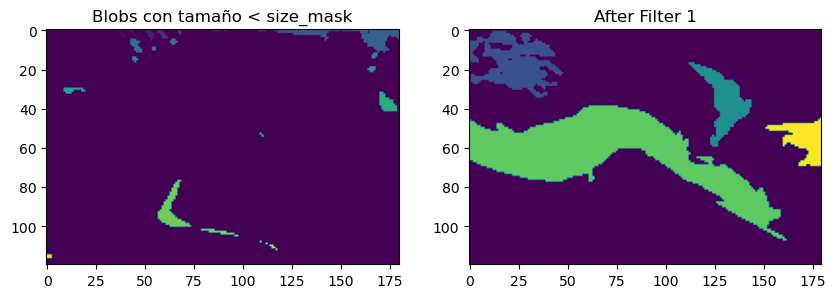

Minimum aspect = 1.6
Minimum length = 25
El blob eliminado tiene relacion de aspecto de 1.47 y largo 45.38 pixeles


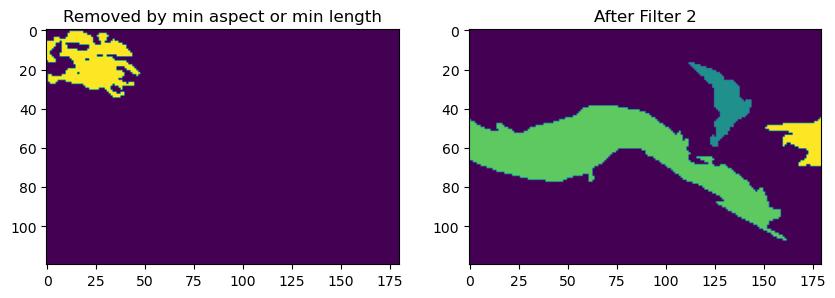

Minimum orientation = 0.95
El blob eliminado tiene orientacion 0.3


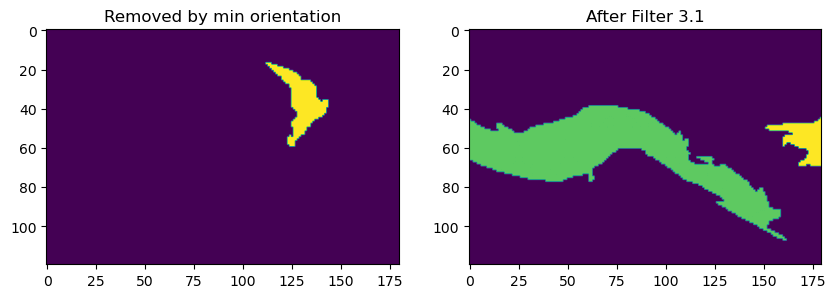

Minimum aspect = 1.6
Minimum length = 25
El blob eliminado tiene relacion de aspecto de 1.48 y largo 30.32 pixeles


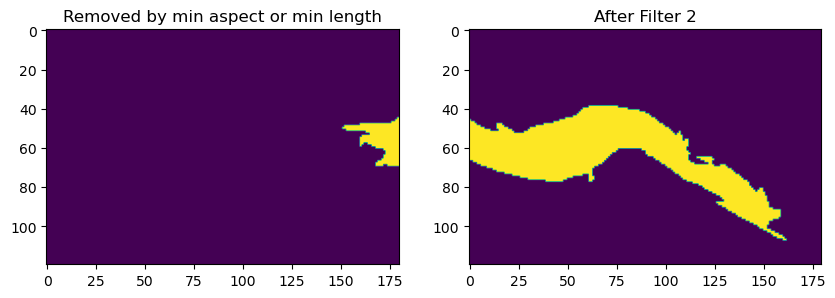

el valor de ii es: 0


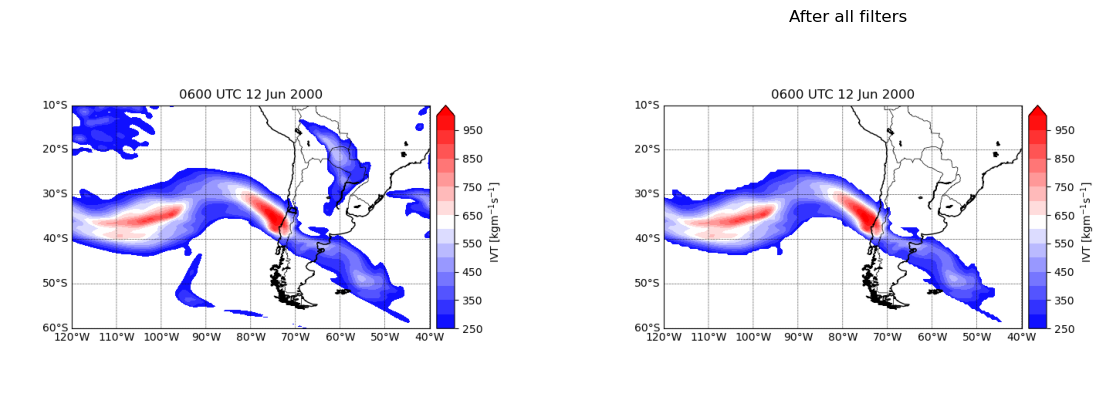

Analizando la hora 12
Working on: 2000 / 06 / 12 / 12 



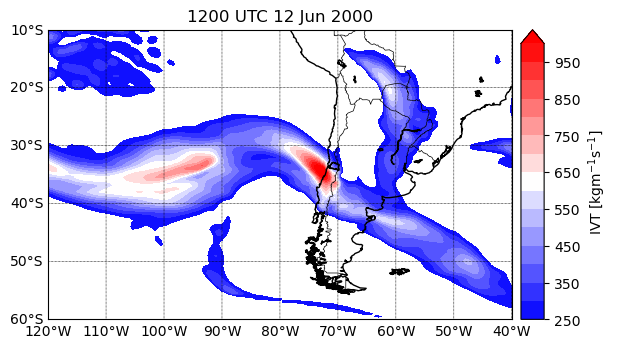

MIN IVT = 250


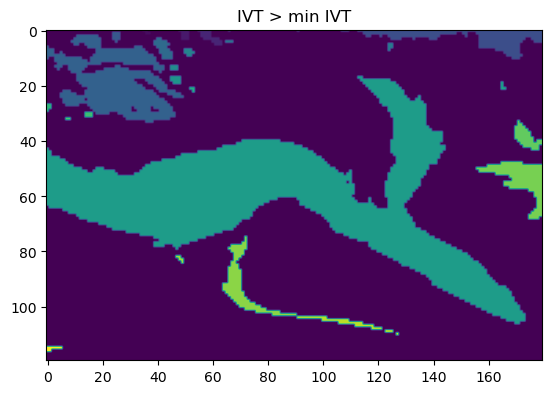

Minimum blob size = 200


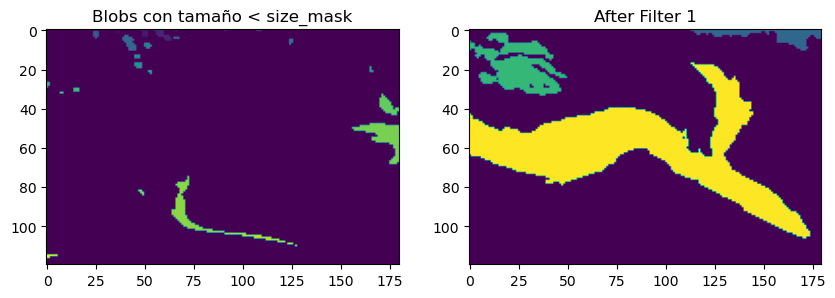

Blob centroid < 20°
El blob eliminado tiene centroide con latitud de 6.0 °


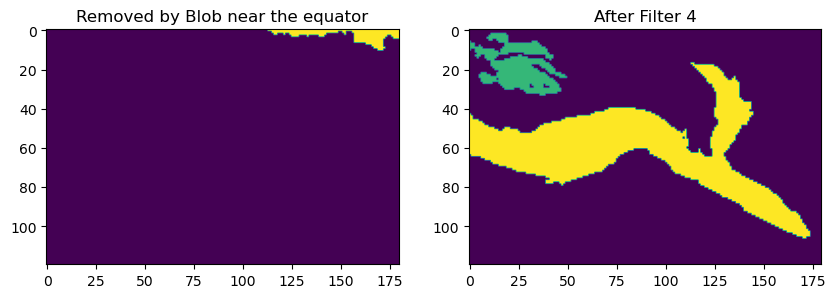

Minimum mean intensity = 305
El blob eliminado tiene intensidad media de 288.02


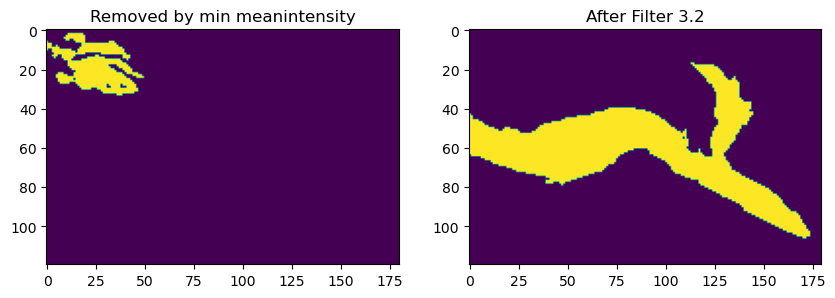

el valor de ii es: 0


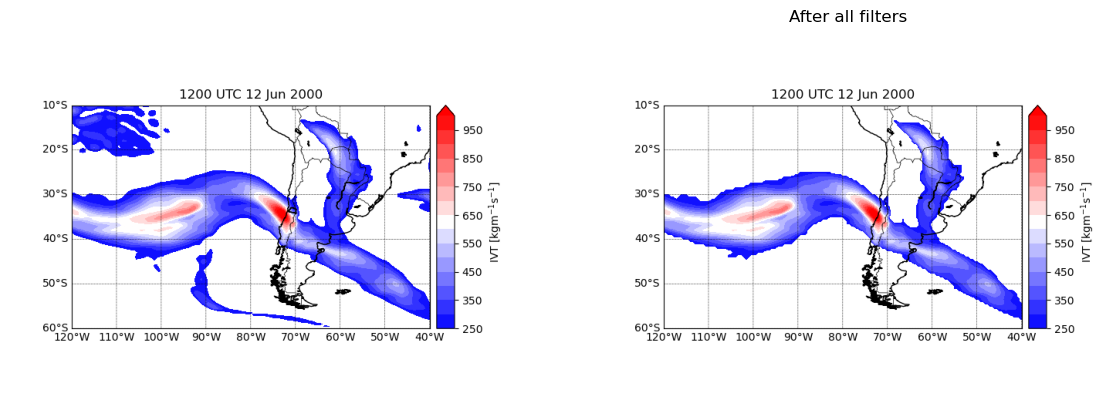

Analizando la hora 18
Working on: 2000 / 06 / 12 / 18 



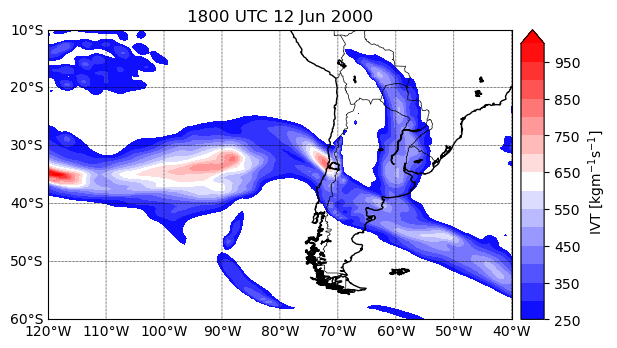

MIN IVT = 250


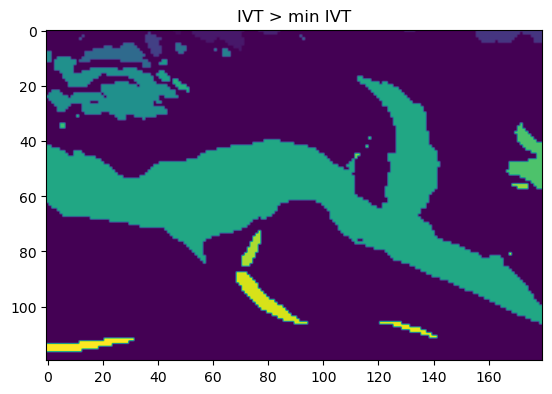

Minimum blob size = 200


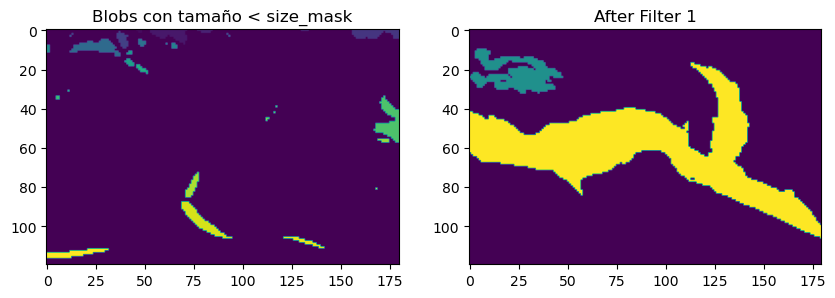

Minimum mean intensity = 305
El blob eliminado tiene intensidad media de 291.15


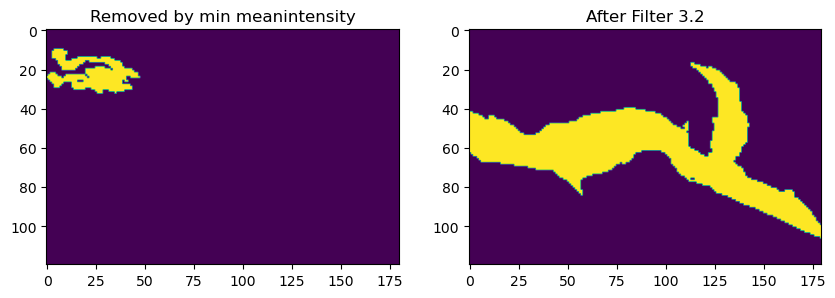

el valor de ii es: 0


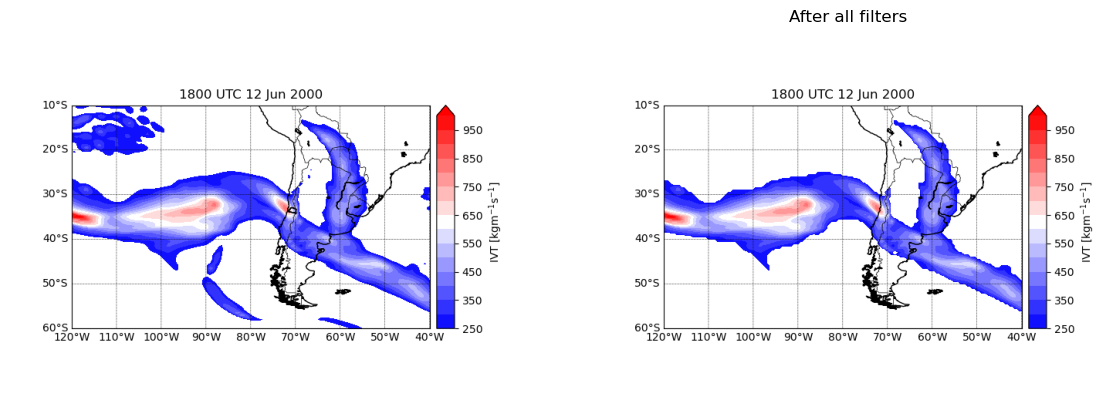

In [8]:
# #____________________________________________________________________________________________________________________________________________________________________________
 
        # Reading top 72hr storm information            #leyendo informacion de tormentas de 72 horas de duracion
# #____________________________________________________________________________________________________________________________________________________________________________

rain      = pd.read_csv( pwd_rain )    # reading the top storm      #se leen los datos de lluvia que estan ubicados en pwd_rain
                                                                            

# Dates to process...
#ii=1, 5, 11, 17,20,23 justifican el no usar filtro 10
for ii in range(0,1):            

#DUDA originalmente era rain.iat[ii,1]    
    date_aux = rain.iat[ii,2]                           #con iat se extrae el valor en la filla ii y columna 2 de la tabla de datos rain  
    
    
    target_years   = [ date_aux[0:4]  ]                 #se obtienen los primeros 4 caracteres de la variable date_aux, es decir, el año 
                                                        #['1979','1980','1981','1982','1983','1984','1985','1986','1987']
    
    target_months  = [ date_aux[5:7]  ]                 #entrega el mes del año que esta en date_aux que se encuentra en la posicion 5 
                                                        #y termina en la posicion 7 (2 caracteres de largo), es decir, entrega:
                                                        #[ '04']   # ['01','02','03','04','05','06','07','08','09','10','11','12']
    
    JM_target_days = [ date_aux[8:10] ]   #[ '02']      #entrega el dia del mes en que ocurrio el evento
    target_hours   = ['00','06','12','18']              #horas objetivo que se utilizaran para buscar los datos de IVT correspondientes
    
# ----------------------------------------------------------
    # Setting Path Variables                            #defininiendo variables de ruta para diferentes host o sistemas en los que
                                                        #se puede ejecutar el codigo
# ----------------------------------------------------------
    
    host = socket.gethostname()                       #entrega el nombre del host en el que se esta ejecutando el codigo
    #print ("El host name del codigo es:", host)
    if host == 'cluster_name':
        sys.exit()                                    #si el nombre del host es cluster_name entonces con la funcion sys.exit()
                                                        #se termina el codigo sin excepciones
    elif host == 'mac_name':                          #se establecen las rutas de acceso
        datapath = 'X'
        outpath  = 'X'                
        resultpath = 'X'
        ncpath = 'X'
    elif host[0:4] == 'node':                         #si el host comienza con la palabra node (primeros 4 caracteres igual a node)
        datapath = 'Y'
        outpath = 'Y'
        resultpath = 'Y'
        ncpath = 'Y'
    else:
        print('Error: Host not found')
        #sys.exit()

    print('Executing on host',host,'\n')

#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________

    # Setting Variables for Feature Testing      #configuracion de variables para pruebas de caracteristicas
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
    
    
    min_IVT           = 250.    # IVT anomaly threshold used to identify blobs          ----> FILTRO 0 (linea 610)                  
                                                            
    size_mask         = 200.    # Minimum blob size allowed for testing                 ----> FILTER 1 (linea 634)            unidad de medida del 200?
                                                                                    
    min_aspect        = 1.6     # Minimum length/width ratio for retained feature       ----> FILTRO 2 (linea 720)                        

    min_orientation   = 0.95    # Minimum orientation (taken as np.abs())               ----> FILTRO 3 (linea 753)                                      

    min_length        = 25.     # Shortest feature length (in pixels)                   ----> FILTRO 2 (linea 720)                   

    min_meanintensity = 305.    # Lowest mean IVT anomaly intensity within a feature    ----> FILTRO 3 (753)                                                                                        
    min_eccentricity  = 0.87    # Minimum eccentricity of a retained feature                                    #excentricidad para ver el caracter filamentoso 
                                                                                                                #mientras mas cercano a 1 mas alargada es la elipse
                                                                                                                #excentricidad=e=c/a=foco/eje mayor
                                                                                                                #ejemplo: excentricidad circulo = 0, elipse larga con e=1
#DUDA        
    lat_cutoff        = 3.0     # Will restrict features centered about the equator         #se restringen las caracteristicas
                                                                                            #que esten a menos de 3° al norte o al sur del ecuador.
#se restringen las caract centradas en el ecuador, ya que la circulacion oceanica y atmosferica es muy distinta en comparacion a las regiones tropicales y subtropicales
    
    
    lat_forceorient   = 20.0    # Threshold for increased testing (mostly TC-focused)           #umbral minimo en el que se 
                                                                                                #realizaran pruebas mas detalladas, es decir, cualquier caracteristica que
                                                                                                #este alejada a mas de 20° del ecuador, ya que estara en la zona tropical 
    
    
    min_forceorient   = 0.5     # Orientation threshold for near-EQ features                    #umbral de orientacion minima para
                                                                                                #caracteristicas cercanas al ecuador
    

# ____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________  
                    # Main Program
#____________________________________________________________________________________________________________________________________________________________________________
# ____________________________________________________________________________________________________________________________________________________________________________
    
    starttime = time.time()    # Setting variable to calculate execution time                   #contador de tiempo para calcular el tiempo de ejecucion
                                                                                    
    
    # # Establishing grid variables                                                             #se crea grilla que cubre todo el mundo con espaciado uniforme
    # lats = np.arange(-90, 90.5, 0.5)                                                          #latitudes van desde -90° a 90.5° con incrementos de 0.5° 
    # lons = np.arange(30, 390, 0.5)                                                            #longitudes van de 30° a 390° con incrementos de 0.5°         
    
    # ur_lat_ind,ur_lat = min(enumerate(lats), key=lambda i: abs(i[1]-bounds[0]))               #lambda se usa para crear funciones pequeñas
                                                                                                
                                                                                                #i es de la forma (indice,valor) de la lista enumerate(lats)
                                                                                                #recordar que indice es la posicion de valor dentro de la lista enumerate(lats)
                                                                                                #lambda devuelve la diferencia entre i[1]=valor y bounds[0]
                    #bounds[0]=limite norte geografico
                    #bounds[1]=limite sur geografico
                    #bounds[2]=limite este geografico
                    #bounds[3]=limite oeste geografico
            #en resumen, ur_lat_ind_ es el indice del valor ur_lat de la latitud que es la mas cercana
            #al limite geografico norte (bounds[0])
    
    # ll_lat_ind,ll_lat = min(enumerate(lats), key=lambda i: abs(i[1]-bounds[1]))               #indice y valor de la latitud mas cercana al limite sur geografico bounds[1]
    
    # ur_lon_ind,ur_lon = min(enumerate(lons), key=lambda i: abs(i[1]-bounds[2]))               #indice y valor de la longitud mas cercana al limite este geografico bounds[2]
                                                                                    
        
    # ll_lon_ind,ll_lon = min(enumerate(lons), key=lambda i: abs(i[1]-bounds[3]))               #indice y valor de la longitud mas cercana al limite oeste geografico bounds[3]
                                                                                    
                                                                                        
    
    
    # sub_lats = lats[ll_lat_ind:ur_lat_ind]                                                #desde el indice de latitud inferior (sur) hasta indice de latitud superior
                                                                                            #(norte) de la lista lats
    # sub_lons = lons[ll_lon_ind:ur_lon_ind]                                                #indice de longitud inferior este hasta indice de longitud superior oeste
    
    
    lon2d_aux = np.loadtxt( pwd_coords + 'cfsr_ch_med_lon.txt',delimiter=',')               #se carga el archivo cfsr_ch_med... que contiene coordenadas de longitud
                                                                                        #pwd_coords es la ruta a la carpeta donde se encuentra el archivo cfsr_ch_med...
    
    
    lat2d_aux = np.loadtxt( pwd_coords + 'cfsr_ch_med_lat.txt',delimiter=',')               #coordenadas de latitud
    nlat,nlon = np.shape(lon2d_aux)                                                         #N° de filas y columnas de matriz lat2d_aux, es decir, N° de latitud y longitud
    #lat2d = lat2d-90
    lon2d_aux = lon2d_aux - 360                                                         #se resta 360 a cada elemento de la matriz lon2d_aux para que se ajuste al rango de
                                                                                        #Python, ya que lat2d_aux, es decir, las latitudes estan en formato de 0 a 360° y 
                                                                                        #python trabaja con -180 a 180 grados
    
#DUDA    
    lon2d = lon2d_aux[190:310, 470:650]                                                 #submatriz que comienza en la fila 190 y col 470 y termina en la fila 310 y col 650
    lat2d = lat2d_aux[190:310, 470:650]                                                 #la submatriz corresponde a una region en especifico. Que region?  
    
    sub_lats = lat2d[:,0]                                                               #latitudes en la region de interes. Es la primera columna de lat2d
    sub_lons = lon2d[0,:]                                                               #longitudes en la region de interes. Es la primera fila de lon2d
    
    nrows = len(sub_lats)                                                               #N° de filas de la matriz sub_lats
    ncols = len(sub_lons)                                                               #N° de columnas de la matriz sub_lons
    

#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
            
                                                        #MASCARA PARA LA CUENCA DEL MAIPO
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
    # Mask for Maipo Basin                 #Mascara para la cuenca del Maipo
    
    mask = np.zeros((nrows, ncols))                                 #matriz mask con el N° de filas nrows de sub_lats y N° de cols ncols de sub_lons

#DUDA     Por que estos numeros?
    mask[57,110] = 1                                                #valor de 1 a la fila 57 y columna 110 de la matriz mask
    mask[58,110] = 1                                                #fila 58 y col 110
    
    mask[56,109] = 1                                                #fila 56 y col 109      
    mask[57,109] = 1
    mask[58,109] = 1
    
    mask[56,108] = 1
    mask[57,108] = 1
    mask[58,108] = 1
    
    mask[57,107] = 1
    mask[58,107] = 1
    
#___________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
#DUDA                       #MASCARA MANUAL?

    # bm.scatter( lon2d[0,110], lat2d[57,0], marker = 'o', color='r', zorder=2)                     #se dibuja un punto rojo "o" con scatter
                                                                                                    #en las coordenadas (lon2d[0,110], lat2d[57,0])
                                                                                                    #lon2d[0,110] es primera fila y col 110 de matriz lon2d
                                                                                                    #lat2d[57,0] es fila 57 y col 0 de matriz lat2d
                                                                                                    #Es la posicion (57,110) de la matriz mask que se establece como 1
                                                                                                    
                
    
    # bm.scatter( lon2d[0,110], lat2d[58,0], marker = 'o', color='r', zorder=2)                     #posicion (58,110) de matriz mask
    
    # bm.scatter( lon2d[0,109], lat2d[56,0], marker = 'o', color='r', zorder=2)
    # bm.scatter( lon2d[0,109], lat2d[57,0], marker = 'o', color='r', zorder=2)
    # bm.scatter( lon2d[0,109], lat2d[58,0], marker = 'o', color='r', zorder=2)
    
    # bm.scatter( lon2d[0,108], lat2d[56,0], marker = 'o', color='r', zorder=2)
    # bm.scatter( lon2d[0,108], lat2d[57,0], marker = 'o', color='r', zorder=2)
    # bm.scatter( lon2d[0,108], lat2d[58,0], marker = 'o', color='r', zorder=2)
    
    # bm.scatter( lon2d[0,107], lat2d[57,0], marker = 'o', color='r', zorder=2)
    # bm.scatter( lon2d[0,107], lat2d[58,0], marker = 'o', color='r', zorder=2)
                    
                    
    
 #___________________________________________________________________________________________________________________________________________________________________________   
 #____________________________________________________________________________________________________________________________________________________________________________
    
    #resultado se guarda en....
    resultpath = 'C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/output/'
    
    if save_csv:                                                    #definido como True para que las caracteristicas AR se guarden en formato CSV
        # Preparing CSV file in which to save AR characteristics   #preparando archivo CSV en el que guardar caracteristicas AR
        csvfname = 'AR_features_'+region_str+'_'+str(datetime.date.today().toordinal())+'.csv'                          #se guarda el archivo con el
                                                                                                                        #nombre AR_features_ seguido de la region region_str y 
                                                                                                                        #seguido de la fecha de hoy en formato ordinal

        fullcsvfile = open( resultpath + csvfname, 'wt')                                                            #se abre el archivo de nombre csvfname ubicado en la ruta
                                                                                                                    #resultpath y en formato de texto (wt)
                                                                                                                    
        cw_full = csv.writer(fullcsvfile, delimiter=',')                                        #se escribe en un archivo CSV mediante la funcion writer
                                                                                                #se escribe en el archivo fullcsvfile y se utiliza delimiter ","
                                                                                                #para separar los valores mediante la coma
        
        
        header = ['yr','mo','dy','hr','id','com_lat','com_lon','n_ext','s_ext','e_ext',         #lista que contiene los nombres de las columnas que se escribiran en el
                  'w_ext','extent_rat','len_km','len_epix','width_epix','orient_deg',           #archivo CSV cw_full
                  'aspect_elw','area_pix','max_intensity','mean_intensity','total_ivta',        
                  'u_mean','v_mean','qc_flag']                                                   
        
        
        
        cw_full.writerow(header)                                                        #se escribe una linea en el archivo cw_full con los valores de header delimitados 
                                                                                        #por coma como se definio al momento de crear el cw_full
    
    
    
    
    outpath  = 'C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/output/'
                                #ruta donde se guarda el archivo generado por el codigo
    
    
    # # Loading array with seasonal cycle of IVT                                                #cargando matriz con ciclo estacional de valores IVT
    # mean_array = np.load(outpath+data_str+'_IVT_'+method_str+'.npy')#\[:,ll_lat_ind:ur_lat_ind,ll_lon_ind:ur_lon_ind]
      
        #se cargan los valores de IVT para cada punto de la grilla, este archivo esta ubicado en la ruta outpath
        #se estan seleccionando todas las filas de la primera dimension  (el tiempo) y las latitudes y longitudes 
        #definidas por los limites ll_lat_ind y ur_lat_ind (latitudes) y ll_lon_ind y ur_lon_ind (longitudes)

#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
 
                #Inicializando contadores de caracteristicas AR
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
    # Initializing counters             #variables que se utilizaran mas adelante para contar caracteristicas AR

    asplen_cnt       = 0               #N° de blobs eliminados debido a que la relacion de aspecto largo/ancho < min_aspect =1.6  or length < min_lengt=25 pixeles
    orint_cnt        = 0               #N° de blobs que no cumplen con la orientacion o intensidad media
    fila_cnt         = 0
    tcish_cnt        = 0
    tchole_cnt       = 0
    tropics_cnt      = 0
    solid_cnt        = 0
    mphole_cnt       = 0
    mp1a_cnt         = 0
    mp1b_cnt         = 0
    mp1c_cnt         = 0
    mpdeg_cnt        = 0
    mp4_cnt          = 0
    blob_cnt         = 0               #N° de blob analizados
    all_retained_cnt = 0
    
    
    counter = -1
    
    
    AR_existence = 0
    AR_duration  = 0
    AR_max       = 0
    


    for yr in target_years:                                             #target_years es una lista de la forma ['1979','1980','1981',...]
        
        counter += 1
        
        print("Analizando el año:", yr) #BB
        
        if operator.mod(int(yr),4) == 0:                                #si el resto de la division entre el año y 4 es 0 entonces el año es bisiesto
            is_leap_year = True                                         #leap es bisiesto
        else:
            is_leap_year = False
    
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
#FALTA TENER LOS DATOS DE VALORES DEL VIENTO PARA ESTA SECCION
    
        # if wind_based_orient:                                         #wind_based_oriente definido como False en control de variables
        #     # 6-hly values of averaged 1000-925 hPa component winds
                                                                        #componentes (u,v) del viento en niveles bajos (1000-928 hPa) cada 6 horas
        #     regional_u = np.load(outpath+region_str+'_lowlvl_u_6hly_'+yr+'.npy')          #se cargan valores promedio del viento #a una altura de 1000-928 hPa
                                                                                            
                                                                                            #outpath es la ruta donde esta guardado el archivo de nombre _lowlvl_u_6hly_
        
        
        
        
        
        #     regional_v = np.load(outpath+region_str+'_lowlvl_v_6hly_'+yr+'.npy')
        #     regional_u = np.where(regional_u == -9999, np.nan, regional_u)                #se reemplazan los valores de -9999 por NaN
        #     regional_v = np.where(regional_v == -9999, np.nan, regional_v)                #NaN = Not a number
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________        
        for mo in target_months:
            
            numdays = days_in_month(yr, mo)                                 #N° de dias del mes del año especificado 
            
            print("Analizando el mes:", target_months)  #BB
            
            
            
            for dy in JM_target_days:    #for dy in range(1, numdays + 1, 1):               #JM_target entrega el dia del mes en que #ocurrio la tormenta
                                                                                        
                print ("Analizando el dia", JM_target_days) #BB
                d_str = str(dy).rjust(2,'0')                                        #para rellener el dia con 2 digitos, es decir, si dy=9 entonces
                                                                                    #con rjust(2,"0") d_str toma el valor 09
                    

                date_str = yr+mo+d_str                  #se crea la fecha en formato YYYYMMDD
                
#Descomentado, se agrega int a dy
                day_index = (datetime.datetime(int(yr),int(mo),int(dy)) - datetime.datetime(int(yr),1,1)).days
                
                                                                        #day_index es el indice del dia del año correspondiente a la fecha yr,mo,dy
                                                                        #es decir, day_index es el N° de dias que han pasado desde el 1 de enero hasta el dia dy del 
                                                                        #mes mo del año yr
                
                if is_leap_year and day_index > 59:
                    day_index = day_index - 1 # Adjusting for leap day                #ajuste de N° de dias para day_index 
                                                                                        #si es que el año es bisiesto
                    
                if save_ar_ivt:   #establecido como True en control de variables
                    aar_ivt_array_3D = np.zeros([len(target_hours),nrows,ncols],dtype=float)            #se crea una matriz 3D llena de ceros con
                                                                                                        #dimensiones cantidad de horas de analisis,
                                                                                                        #N° de filas y N° de cols de la malla de datos de IVT
                    
                #inicialmente estaba en 00, lo cambie a 06 para graficar el AR del pdf Memoria_AR
                for hr_ind,hr in enumerate(['00','06','12','18']): #for hr_ind,hr in enumerate(['00','06','12','18']):
                    print ("Analizando la hora", hr)                                                                                            #hr_ind toma el valor 0 y hr toma el valor 00
                    
                    print('Working on:', yr,"/", mo,"/", dy,"/", hr, '\n')                              #se imprime la hora y fecha (YYYYMMDD) que se esta procesando
                                                                                        
                    if hr in target_hours: # Allows for the processing of subset of 6-hly periods         #permite el procesamiento de subconjuntos de periodos de 6 horas
                                                                                                        
                                                                                                
                        dtg_str = date_str + '/'+hr                   #se concatena fecha y hora 
                        dtg_ind = (day_index*4)+hr_ind                #ubicacion de la hora en la matriz de datos
                                                                        #day_index es el numero de dias transcurridos
                        
                    
                    # # Reading in pre-processed IVT data   --> JM_notes: this function basically read the IVT grid and changue the coordinate system from -180 > 180 to 30 > 390 
                    # transformed_ivt_array = retrieve_data(date_str,hr_ind)\[ll_lat_ind:ur_lat_ind,ll_lon_ind:ur_lon_ind]
                      
                                            #esta funcion transforma el sistema de coordenadas de los datos de IVT desde un rango de
                                            #longitud de -180 a 180 a uno de 30 a 390
                    
                    # # Removing seasonal cycle to create IVT anomaly array                     #se elimina el ciclo estacional para crear
                                                                                                #una matriz de anomalias de valores IVT
                    # ivt_anom = transformed_ivt_array - mean_array[day_index,:,:]
                    
                                                                                        #ivt_anom es una matriz que indica la diferencia entre los valores de IVT "normales"
                                                                                        #con los valores de la fecha y hora especificada

                    # JM_Reading the IVT files
                    # -----------------------------------------------------------------
                    
                    date_temp = datetime.datetime( int(yr), int(mo), int(dy) )          #se almacena la fecha de la forma year-month-day
                                                                                    
                    
                    
                    
                    inpf_name = pwd_ivt + '/IVT_3A'+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ \
                                    "-"+'{0:02d}'.format(date_temp.day)+"_"+ hr +".bin"
                    
                                            #inpf_name es la ruta de acceso al archivo bin de IVT con fecha y hora.
                                            #Ejemplo: pwd_ivt es la ruta de acceso y el archivo se llama IVT_3A1980-04-02_00.bin
                    
                    #print("El inpf_name es:", inpf_name, '\n')
                   
                    # Load daily binary file of the day                             #cargando el archivo binario diario del dia
                    ivt_anom = np.fromfile(inpf_name,dtype='<f')                    #se lee el archivo en binario inpf_name
                                                                    
                    
                    ivt_anom = ivt_anom[1:-1] #remove extra sector generated by fortran formattting         #se elimina un elemento extra generado por el formato fortran
                                                                                                        
                    
                    
                    ivt_anom = ivt_anom.reshape(nlat,nlon)                              #se pasa a una matriz bidimensional de nlat filas y nlon COLUMNAS
                                                                
                    ivt_anom = ivt_anom[190:310, 470:650]                           #se extrae una submatriz desde la fila 190 y col 470 hasta la fila 310 y col 650
                    
                    
                    ivt_basin = ivt_anom * mask                             #se obtienen los valores de IVT dentro de la cuenca mask
                                                                            #valores fuera de la cuenca tiene valor=0
                    
                    
                    if( sum(sum(ivt_basin)) > 0 and AR_existence == 0 ):                #si la suma dentro de ivt_basin es >0
                        AR_existence = 1                                                #y si aun no se encuentra ni un AR
                                                                                        #entonces AR_existence=1, es decir, se ha
                                                                                        #encontrando un AR en la cuenca
                    
                    
                    if( sum(sum(ivt_basin)) > 0 ):
                        AR_duration += 1                                    #se aumenta AR_duration para medir la duracion del evento AR
                        
                    
                    if( ivt_basin.max() > AR_max ):  
                        AR_max = ivt_basin.max()                        #se actualiza el valor de AR_max si es que en ivt_basin hay un
                                                                        #valor mayor
                   
                    

                    basinshape = 'C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/Maipo_shapefile_EPSG_4326/Cuenca_Maipo_EPSG_4326'
                    # Draw IVT                                  #basinshape tiene la direccion de la ubicacion del archivo
                    plt.figure()                                #shape que tiene info sobre la geometria de la cuenca  
                    # plt.hold(True)                            #del rio maipo
                                                                #luego se dibuja el IVT
                    
#____________________________________________________________________________________________________________________________________________________________________________                    
                    ### basemap
                    #bm = Basemap(llcrnrlon=np.min(lon2d),llcrnrlat=np.min(lat2d),urcrnrlon=np.max(lon2d),urcrnrlat=np.max(lat2d),resolution='l')

                                                                #se establecen los limites y resolucion del mapa que se va a graficar
                                
                    #bm = Basemap(llcrnrlon=-130,llcrnrlat=35,urcrnrlon=-105,urcrnrlat=60,resolution='i')
                    
                                                                #mapa con longitudes desde -130 a -105° oeste y entre 35 y 60° latitud norte 
                                                                #i indica resolucion intermedia

#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
 
                                        #Creando grafico de AR
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________                            
                    bm = Basemap(llcrnrlon=-120,llcrnrlat=-60,urcrnrlon=-40,urcrnrlat=-10,resolution='l')
                    #Large                              
                                #llcrnrlon=lower left corner longitude
                                #llcrnrlat=lower left corner latitude
                                #urcrnrlon=upper right corner longitude
                                #urcrnrlat=uperr right corner latitude
                                
                    bm.drawcoastlines()                 #se dibujan las lineas costeras en el mapa
#DUDA                    # bm.drawstates()              #se dibujan las fronteras de los estados de USA
                    bm.drawcountries()                  #se dibujan los contornos de los paises en el mapa

                    bm.readshapefile(basinshape,'Basin',color='k',linewidth=1)          #se cargan los datos del archivo
#esto lo comente yo porque me falta el archivo shape                                    #contenido en la ruta basinshape
                                                                                        #y se le asigna el nombre de basin para poder
                                                                                        #llamarlo asi posteriormente en el codigo
                                
                    bm.drawmeridians(np.arange(0,360,10),labels=[0,0,0,1], linewidth=0.5)       #se dibujan meridianos desde
                                                                                                #el 0 hasta el 360 con
                                                                                                #incrementos de 10°
                                                                                                #con labels se imprimen etiquetas en el lado derecho del mapa      
                                
                    bm.drawparallels(np.arange(-90,90,10),labels=[1,0,0,0],linewidth=0.5)       #se dibujan los paralelos
                                                                                                #cada 10° partiendo desde
                                                                                                #-90 hasta 90
                                                                                                #las etiquetas estan ubicadas en el meridiano 0
    
                    LON,LAT = bm(lon2d,lat2d)                           #lon2d y lat2d son matrices de longitud y latitud de la cuenca
                                                                        #del rio maipo
                
                                    #se convierte las coordenadas geograficas en la proyeccion de mapa que se esta
                                    #usando mediante la funcion bm
    
                    level = np.arange(250,1050,50)          #valores de presion atmosferica desde 250 a 1050 hPa con incrementos de 50hPa
                                                            
            
              
                    #######################################################################
                    cs = bm.contourf(LON,LAT,ivt_anom ,level,cmap=plt.cm.bwr, extend='max')
                    
                                        #cs es el mapa de colores que tiene los valores de IVT sobre la region estudiada
                                                    #LON y LAT son las coord transformadas con el mapa base
                                                    #ivt_anom es el campo de datos que contiene la anomalia de IVT
                                                    #con level se construyen los contornos de color en el mapa
                                                    #con cmap se especifica la escala de colores
                                                    #extend hace que se muestren del mismo color que el valor maximo
                                                    #los valores que excedan el rango del mapa
                                
                    
                    cbar = bm.colorbar(cs, location='right', size='5%', pad='2%', fig=None, ax=None)  
                    
                                        #barra de color ubicada a la derecha del mapa
                                        #ocupa el 5% del mapa
                                        #se separa un 2% del mapa en si
                                                                                                    
                    cbar.set_label('IVT [kgm$^{-1}$s$^{-1}$]')              #etiqueta de la barra cbar
                    #######################################################################
    
    
                    plt.title( hr +"00 UTC "+date_temp.strftime("%d %b %Y"))        #titulo de la figura con fecha y hora UTC 
                    plt.tick_params(axis='x', which='major', labelsize=4)          #se modifican las marcas principales
                                                                                    #del eje x
                    
                    fig_name = "IVT" + "_"+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ \
                                "-"+'{0:02d}'.format(date_temp.day)+'_'+ hr +".jpg"
                                
                        #fig_name contiene el nombre del archivo que tiene la imagen.
                        
                    pwd_aux =   pwd_save + str(rain.at[counter,'CR2MET']) + '_'  + str(rain.at[counter,'72hr_period']) + '/'       
                                
                    #se lee el archivo rain
                    #se accede al valor ubicado en la fila counter y columna CR2MET
                    #tambien se accede al valor en la fila counter y columna 72hr_period2
                    #se unen las 2 variables mediante el _
                    
                    ar_inicial = plt.gcf()
                    ar_inicial.savefig('C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/imagenes/ar_inicial-'+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ "-"+'{0:02d}'.format(date_temp.day)+"_"+ hr + '.png')

#comentado BB                    #plt.savefig( pwd_aux + fig_name,dpi=400)            #se guarda la imagen fig_name en la ruta pwd_aux +fig_name
                    plt.show()   #muestra la figura                     #en formato jpg y con resolucion de 400 dpi
                    plt.close()   #cierra la figura para ahorrar memoria
                    
#____________________________________________________________________________________________________________________________________________________________________________                    
#____________________________________________________________________________________________________________________________________________________________________________
                                
                                 #Fin grafico AR
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________            
    

          #Esta seccion define otra zona geografica para graficar 
#____________________________________________________________________________________________________________________________________________________________________________                
                    # plt.figure()
                    # # plt.hold(True)          #funcion que ya no se usa, es para indicar si los nuevos graficos se
                                                #superponen a los graficos antiguos pero esto ahora se hace por defecto
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________ 
        #aca se define otra zona geografica distinta a la anterior
    
                    # ### basemap
                    # #bm = Basemap(llcrnrlon=np.min(lon2d),llcrnrlat=np.min(lat2d),urcrnrlon=np.max(lon2d),urcrnrlat=np.max(lat2d),resolution='l')
                    # #bm = Basemap(llcrnrlon=-130,llcrnrlat=35,urcrnrlon=-105,urcrnrlat=60,resolution='i')
                    # bm = Basemap(llcrnrlon=-75,llcrnrlat=-40,urcrnrlon=-65,urcrnrlat=-30,resolution='l')
                    # #Large
    
    
                    # bm.drawcoastlines()
                    # # bm.drawstates()
                    # bm.drawcountries()
                    # bm.readshapefile(basinshape,'Basin',color='k',linewidth=1)
    
                    # bm.drawmeridians(np.arange(0,360,2),labels=[0,0,0,1], linewidth=0.5)
                    # bm.drawparallels(np.arange(-90,90,2),labels=[1,0,0,0],linewidth=0.5)
    
                    # LON,LAT = bm(lon2d,lat2d)
    
                    # level = np.arange(250,1050,50)
                    # #######################################################################
                    # cs = bm.contourf(LON,LAT,ivt_anom,level,cmap=plt.cm.bwr, extend='max')
                    # cbar = bm.colorbar(cs, location='right', size='5%', pad='2%', fig=None, ax=None)
                    # cbar.set_label('IVT [kgm$^{-1}$s$^{-1}$]')
                    # #######################################################################
    
    
                    # plt.title( hr +"00 UTC "+date_temp.strftime("%d %b %Y"))
                    # #plt.tick_params(axis='x', which='major', labelsize=4)
                    
                    # fig_name = "IVT" + "_"+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ \
                    #             "-"+'{0:02d}'.format(date_temp.day)+'_'+ hr +".jpg"
                                
                    # pwd_aux =   pwd_save + str(rain.at[counter,'CR2MET']) + '_'  + str(rain.at[counter,'72hr_period']) + '/'       
                                
                                                
#hasta aqui es lo mismo que antes solo que se utiliza otra area geografica
#____________________________________________________________________________________________________________________________________________________________________________                    
#____________________________________________________________________________________________________________________________________________________________________________

    #esta parte ya esta comentada mas arriba (linea 185)           
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________  
                    
                    # bm.scatter( lon2d[0,110], lat2d[57,0], marker = 'o', color='r', zorder=2)
                    # bm.scatter( lon2d[0,110], lat2d[58,0], marker = 'o', color='r', zorder=2)
                    
                    # bm.scatter( lon2d[0,109], lat2d[56,0], marker = 'o', color='r', zorder=2)
                    # bm.scatter( lon2d[0,109], lat2d[57,0], marker = 'o', color='r', zorder=2)
                    # bm.scatter( lon2d[0,109], lat2d[58,0], marker = 'o', color='r', zorder=2)
                    
                    # bm.scatter( lon2d[0,108], lat2d[56,0], marker = 'o', color='r', zorder=2)
                    # bm.scatter( lon2d[0,108], lat2d[57,0], marker = 'o', color='r', zorder=2)
                    # bm.scatter( lon2d[0,108], lat2d[58,0], marker = 'o', color='r', zorder=2)
                    
                    # bm.scatter( lon2d[0,107], lat2d[57,0], marker = 'o', color='r', zorder=2)
                    # bm.scatter( lon2d[0,107], lat2d[58,0], marker = 'o', color='r', zorder=2)
                    
                    
                    
                    # plt.savefig( pwd_aux + fig_name,dpi=400)
                    # plt.show()
                    # plt.close()
                    
                  
        
#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 0 IVT>IVT_MIN
#____________________________________________________________________________________________________________________________________________________________________________                    
                                                                                                
                    threshold_array = np.where(ivt_anom > min_IVT, 1, 0)                        ##threshold = umbral. Si el valor de ivt_anom es > a min_IVT entonces
                                                                                                
                    label_array, num_labels = ndimage.label(threshold_array)                    #threshold_array toma el valor 1 sino 0
                                                                                                                                                                                        
                    sizes = ndimage.sum(threshold_array, label_array, range(num_labels + 1))    #threshold es una mascara para guardar las posiciones donde IVT > IVT min
                                                                                                
                    print ("MIN IVT = 250")                                                     #num_labels indica el N° de etiquetas diferentes en la imagen
                    plt.figure()                                                                #label_array son las regiones identificadas con IVT > IVT min
                    plt.title( 'IVT > min IVT')                                                 #Removing small blobs (aka features of interest) from remaining IVT anomaly field
                    plt.imshow(label_array)                                                     #tamaño de cada region etiquetada
                    plt.show()
                    ar_inicial_mask = plt.gcf()
              #      ar_inicial_mask.savefig('C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/imagenes/ar_inicial_mask-'+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ "-"+'{0:02d}'.format(date_temp.day)+"_"+ hr + '.png')
                    plt.close()


#____________________________________________________________________________________________________________________________________________________________________________

            # FILTRO 1: elimina regiones con tamaño menor al size_mask
#____________________________________________________________________________________________________________________________________________________________________________
                    
                    mask_size = sizes < size_mask 
                    remove_blob = mask_size[label_array]                                                #indices de las regiones a remover que estan en label_array                                            
##BB___________________________________________________________________________________________
                    blob_elim=label_array.copy()
                    blob_elim[~remove_blob] = 0                                                         #Valor de cero a los elementos de blob_elim qu NO estan en remove_blob
##BB___________________________________________________________________________________________                    
                    label_array[remove_blob] = 0                                                        #regiones a eliminar se les asigna valor 0
                    labels = np.unique(label_array)                                                    #reetiquetado de las regiones despues de eliminar los de tamaño menor a size_mask                                                                                                                                                                                          
                    label_array = np.searchsorted(labels, label_array)       
                    blob_cnt += np.count_nonzero(labels)                                                #N° total de blobs o regiones que cumplen con las condiciones 
                    blob_props = regionprops( label_array, intensity_image=ivt_anom)                    #se calculan propiedades de las regiones (blobs) como area,                                                                                                 
                                                                                                        #centroide, excentricidad , etc. Ademas se agrega
                                                                                                        #intensity_image=ivt_anom para calcular propiedades
                                                                                                        #relacionadas a la intensidad como desv. estandar, media, etc.
                    # [r.area for r in blob_props]
                    print ("Minimum blob size = 200")
                    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
                    plt.subplot(1, 2, 1)
                    plt.title('Blobs con tamaño < size_mask')
                    plt.imshow(blob_elim)
                    plt.subplot(1, 2, 2)
                    plt.title('After Filter 1')
                    plt.imshow(label_array)
                    plt.show()
                    fig.tight_layout()



                                # FIN FILTRO 1
#____________________________________________________________________________________________________________________________________________________________________________

                #Estimando las caracteristicas (length, width, area, aspect, orientation) de cada blob
#____________________________________________________________________________________________________________________________________________________________________________
               #     print('Estimating each blob characteristics', '\n')         #estimacion de las caract de cada blob  
                    # --------------------   
                    retained_cnt = 0 # Will use to renumber retained blobs      #para renombrar los blobs retenidos
                    # Initializing lists of CoM locations and blob labels for plotting 
                    clats,clons,blabels = [],[],[]

#BB__________________________________________________________________________________________________________________________________________________________________________
                    blobs_elim= np.zeros_like(label_array)
#BB__________________________________________________________________________________________________________________________________________________________________________                    

                    # Testing each blob to determine if it may be an AR         #se examina cada blob (mancha) obtenido despues del
                    for i,blob in enumerate(blob_props):                        #filtro 1 para saber si es una region AR
                        logic_flag = 'na'
                        qc_flag = 'na'
                        true_orient = 'na'
                        orientation = blob.orientation          #orientacion
                        length = blob.major_axis_length         #longitud eje mayor (largo) 
                        width = blob.minor_axis_length          #longitud eje menor (ancho)
                        area = blob.area                        #tamaño en pixeles del objeto detectado
                        excentricidad =blob.eccentricity
                        if width > 0.:
                            aspect = length/float(width)        #relacion largo/ancho 
                        else:
                            aspect = 0
                        meanint = blob.mean_intensity           #intensidad media
                        y0, x0 = blob.weighted_centroid         #ubicacion centroide
                        
                  #      print('Analizando el blob N°',i+1,' -->  length = ', "{:.2f}".format(length),' and width = ',"{:.2f}".format(width),' and area = ', "{:.2f}".format(area),' and aspect = ', "{:.2f}".format(aspect) , ' and orientation = ', "{:.2f}".format(orientation), ' and eccentricity = ', "{:.2f}".format(excentricidad) )
                 #       print('El centroide del blob N°', i+1,'tiene coordenadas y0 = ', "{:.2f}".format(y0), ' and x0 = ', "{:.2f}".format(x0), '\n')
                                


#____________________________________________________________________________________________________________________________________________________________________________ 

            #FILTRO 2: Verifica la relacion de aspecto y longitud minima 
#____________________________________________________________________________________________________________________________________________________________________________
                        
                        if (aspect < min_aspect or length < min_length):  
                            blobs_elim= np.zeros_like(label_array)
                            blobs_elim[label_array==blob.label]=1
                            label_array[label_array == blob.label] = 0                                  #se establecen en 0 los elementos que tienen valor igual a blob.label                                                              
                            
                            print ("Minimum aspect = 1.6")
                            print ("Minimum length = 25")
                            print ("El blob eliminado tiene relacion de aspecto de", round(aspect,2), "y largo", round(length,2),"pixeles")
                            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
                            plt.subplot(1, 2, 1)
                            plt.title('Removed by min aspect or min length')
                            plt.imshow(blobs_elim)
                            plt.subplot(1, 2, 2)
                            plt.title('After Filter 2')
                            plt.imshow(label_array)
                            plt.show()
                            fig.tight_layout()

                            logic_flag = 'asp-len'                                              #para indicar que el objeto fue eliminado debido a problemas de 
                                                                                                #relacion aspecto/longitud
                            asplen_cnt += 1                                                     #cuenta el N° de objetos eliminados debido a la relacion de aspecto                        
                                                                                                #si el objeto no cumple con lo minimo entonces se 



#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 3.1: Orientacion minima
#____________________________________________________________________________________________________________________________________________________________________________                         
#descomentado ok (se agrega int a variable y0)
#condicion original es abs(sub_lats[int(y0)]) < lat_forceorient and
# (abs(orientation) < min_orientation) or (meanint < min_meanintensity)
         
                        elif (abs(orientation) < min_orientation):
                            blobs_elim= np.zeros_like(label_array) 

                            blobs_elim[label_array==blob.label]=1
                            label_array[label_array == blob.label] = 0
                            logic_flag = 'or-int'
                            orint_cnt += 1 
                            
                            print ("Minimum orientation = 0.95")
                            print ("El blob eliminado tiene orientacion", round(orientation,2))
                            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
                            plt.subplot(1, 2, 1)
                            plt.title('Removed by min orientation')
                            plt.imshow(blobs_elim)
                            plt.subplot(1, 2, 2)
                            plt.title('After Filter 3.1')
                            plt.imshow(label_array)
                            plt.show()
                            fig.tight_layout()



#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 3.2: Intensidad media minima
#____________________________________________________________________________________________________________________________________________________________________________                         
#descomentado ok (se agrega int a variable y0)
#condicion original esta comentada en 3.1 
#se separo este filtro para mejor visualizacion

                        elif (meanint < min_meanintensity):
                            blobs_elim= np.zeros_like(label_array)                                  # Clearing the blobs that do not meet the orientation or mean intensity
                            blobs_elim[label_array==blob.label]=1
                            label_array[label_array == blob.label] = 0
                            logic_flag = 'or-int'
                            orint_cnt += 1 

                            print ("Minimum mean intensity = 305")
                            print ("El blob eliminado tiene intensidad media de", round(meanint,2))
                            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
                            plt.subplot(1, 2, 1)
                            plt.title('Removed by min meanintensity')
                            plt.imshow(blobs_elim)
                            plt.subplot(1, 2, 2)
                            plt.title('After Filter 3.2')
                            plt.imshow(label_array)
                            plt.show()
                            fig.tight_layout()


#____________________________________________________________________________________________________________________________________________________________________________                
                    
            #FILTRO 4: Se eliminan blobs cercanos al ecuador.     
#____________________________________________________________________________________________________________________________________________________________________________
#descomentado ok (se agrega int a variable y0)
#la condicion original es (abs(sub_lats[int(y0)]) < lat_forceorient and 
# blob.eccentricity < min_eccentricity) or (abs(sub_lats[int(y0)]) >= lat_forceorient and 
# blob.eccentricity < min_eccentricity - 0.1):
#(antes se llamaba: que no cumplen con las caracteristicas filamentosas)
                   
                        elif (abs(sub_lats[int(y0)]) < lat_forceorient ):                               # Attempting to filter out blobs that lack "filament-like" character
                            blobs_elim= np.zeros_like(label_array)
                            blobs_elim[label_array==blob.label]=1
                            label_array[label_array == blob.label] = 0
                            logic_flag = 'filament'
                            fila_cnt += 1
                            
                            print ("Blob centroid < 20°")
                            print ("El blob eliminado tiene centroide con latitud de", abs(sub_lats[int(y0)]),"°")
                            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
                            plt.subplot(1, 2, 1)
                            plt.title('Removed by Blob near the equator')
                            plt.imshow(blobs_elim)
                            plt.subplot(1, 2, 2)
                            plt.title('After Filter 4')
                            plt.imshow(label_array)
                            plt.show()
                            fig.tight_layout()


#____________________________________________________________________________________________________________________________________________________________________________                
                    
            #FILTRO 5: Elimina manchas redondas, solidas e intensas que pueden ser tormentas tropicales  
                        #manchas redondas son elimidas con blob.extent, comando que divide el area del blob con el area de un rectangulo que lo envuelve
#____________________________________________________________________________________________________________________________________________________________________________
#descomentado ok (se agrega int a variable y0)

                        elif abs(sub_lats[int(y0)]) < (lat_forceorient + 5.) and blob.eccentricity > min_eccentricity and blob.mean_intensity > 375 and blob.extent > .50:
                             
                            blobs_elim= np.zeros_like(label_array)
                            blobs_elim[label_array==blob.label]=1                            
                            
                            label_array[label_array == blob.label] = 0
                            logic_flag = 'tc-like'
                            tcish_cnt += 1

                            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
                            plt.subplot(1, 2, 1)
                            plt.title('blobs redondos, solidos o intensos')
                            plt.imshow(blobs_elim)
                            plt.subplot(1, 2, 2)
                            plt.title('After Filter 5')
                            plt.imshow(label_array)
                            plt.show()
                            fig.tight_layout()


#____________________________________________________________________________________________________________________________________________________________________________                
                    
            #FILTRO 6: Elimina manchas que tienen agujeros  
#____________________________________________________________________________________________________________________________________________________________________________                
#descomentado ok (se agrega int a variable y0)

                        elif abs(sub_lats[int(y0)]) < lat_forceorient and (int(blob.area) - blob.filled_area) <= -5:
                             # Removing blobs with sizeable holes (mostly TCs "eyes")
                            blobs_elim= np.zeros_like(label_array)
                            blobs_elim[label_array==blob.label]=1                    

                            label_array[label_array == blob.label] = 0
                            logic_flag = 'tc-hole'
                            tchole_cnt += 1

                            print ("El blob eliminado tiene area total de", int(blob.area), "y un area rellena de ", blob.filled_area)
                            print ("Por lo tanto, el area de pixeles vacios o huecos es de ", int(blob.area) - blob.filled_area)

                            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
                            plt.subplot(1, 2, 1)
                            plt.title('Blobs con agujeros')
                            plt.imshow(blobs_elim)
                            plt.subplot(1, 2, 2)
                            plt.title('After Filter 6')
                            plt.imshow(label_array)
                            plt.show()
                            fig.tight_layout()
                        

#____________________________________________________________________________________________________________________________________________________________________________                

            #FILTRO 7: Elimina manchas fuera de la region y que pueden ser ciclones tropicales   
#____________________________________________________________________________________________________________________________________________________________________________
#descomentado ok (se agrega int a variable y0)
#se le agrega el  or (abs(sub_lats[int(y0)])>55) para sacar blobs con centroide mayor a la latitud 55°

                        elif abs(sub_lats[int(y0)]) <= lat_cutoff or (abs(sub_lats[int(y0)]) <= lat_forceorient ) or (abs(sub_lats[int(y0)])>55) :

                            blobs_elim= np.zeros_like(label_array)                                          #Further scrutinizing blobs in the tropics to remove
                            blobs_elim[label_array==blob.label]=1                                               #west-east features along ITCZ

                            label_array[label_array == blob.label] = 0
                            logic_flag = 'tropics'
                            tropics_cnt += 1
                         
                            print ("Blobs con centroide fuera de la region, es decir, con latitudes menores a 20° o mayores a 55°")
                            print ("El Blob eliminado tiene centroide con latitud de", str(abs(sub_lats[int(y0)]))+"°")   

                            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6),sharex=True, sharey=False)
                            plt.subplot(1, 2, 1)
                            plt.title('Blobs out of region')
                            plt.imshow(blobs_elim)
                            plt.subplot(1, 2, 2)
                            plt.title('After Filter 7')
                            plt.imshow(label_array)
                            plt.show()
                            fig.tight_layout()


#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 8: Elimina manchas elipticas
#____________________________________________________________________________________________________________________________________________________________________________

                        elif( aspect < 1.90 and blob.solidity > 0.90 and blob.extent > 0.40):               #RELACION DE ASPECTO, SOLIDEZ Y EXTENSION                                                                                             
                                                                                                                #Attempting to allow for curvature of AR, but removing
                                                                                                                #"solid" eliptical blobs
                            label_array[label_array == blob.label] = 0                                          #se elimina blob
                            logic_flag = 'solid'                                                                #para indicar que fue eliminado el blob por solid
                            solid_cnt += 1                 
                                                                                                                 #se actualiza contadaor para contar los blobs eliminados
                            plt.figure()
                            plt.title( 'Filtro 8, blobs elipticos linea 950')
                            plt.imshow(label_array)
                            plt.show()                                                                    


#____________________________________________________________________________________________________________________________________________________________________________                                                            
            #PRUEBAS ADICIONALES A BLOBS RESTANTES (MAXIMOS LOCALES), si hay peaks entonces se segmenta el blob
#____________________________________________________________________________________________________________________________________________________________________________                            
                        else:
                            # Performing additional tests on a blob that would otherwise be retained
                            temp_mask = np.zeros([nrows,ncols])                                              #pruebas adicionales de un objeto
                            temp_mask[label_array == blob.label] = 1                           
                            peaks = peak_local_max(ivt_anom*temp_mask, min_distance=14, num_peaks=4) #maximos locales en ivt_anom, num_peaks es el max de picos que se pueden encontrar
                            
                            if len(peaks) > 1:                                              #si hay mas de un maximo entonces se considera el objeto como compuesto
                                blob_image_array = ivt_anom * (label_array == blob.label)   #entonces se debe segmentar
                                bigblob_mask = np.ones([nrows,ncols]) * -1
                                bigblob_mask[label_array == blob.label] = 0
                                
                                

                                blobs_elim2= np.zeros_like(label_array)
                                for peak_ind, peak_coords in enumerate(peaks):
                                    bigblob_mask[peak_coords[0],peak_coords[1]] = peak_ind+1

#DUDA, CAMBIE EL VALOR DE BETA DE 75 A 0
                                     
                                segmented_blob = random_walker(blob_image_array, bigblob_mask, beta=0)  #beta 75 originalmente
                                
                                for sub_label in np.unique(segmented_blob):
                                    if sub_label == -1:
                                        continue
                                        # -1 is the background; negative values are ignored
                                    else:
                                        segmented_blob_mask = np.zeros([nrows,ncols],dtype='int')
                                        segmented_blob_mask[segmented_blob == sub_label] = sub_label
                                        segment_props = regionprops(segmented_blob_mask,intensity_image=ivt_anom)  #propiedades de la imagen segmentada
                                        sy0, sx0 = segment_props[0].weighted_centroid                       
                      #                  print ("blolb segmentado con coordenadas sy0 y sx0:", sy0, sx0, "respectivamente")                                                               
                                         #sy0 y sx0 son las coordenadas del centroide de la region segmentada (subregion)
                                                     



#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 9: Elimina manchas con agujeros
#____________________________________________________________________________________________________________________________________________________________________________
#descomentado ok (se agrega int a variable sy0)
#PROBLEMAS CON ESTE FILTRO 
#condicion original abs(sub_lats[int(sy0)]) < (lat_forceorient + 7.5) and int(segment_props[0].area) != segment_props[0].filled_area:
                                  
                                    if (abs(sub_lats[int(sy0)]) < (lat_forceorient+7.5) or abs(sub_lats[int(sy0)]) > 55 ) and int(segment_props[0].area) != segment_props[0].filled_area:    
                                                                                                                                            
                                        segmented_blob_mask[segmented_blob == sub_label] = 0                      #Removing segments with noticeable holes (i.e., mostly TCs)

                                        print ("El blob eliminado tiene area total de", int(segment_props[0].area), "y un area rellena de ", segment_props[0].filled_area)
                                        print ("Por lo tanto, el area de pixeles vacios o huecos es de", segment_props[0].filled_area - int(segment_props[0].area))


                                        label_array[segmented_blob == sub_label] = 0
                                        qc_flag = 'segment'
                                        logic_flag = 'multi-peak-hole'
                                        mphole_cnt += 1
   
                                        plt.figure()
                                        plt.title( 'After Filter 9')
                                        plt.imshow(label_array)
                                        plt.show()   


#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 10: min eccentricity
#____________________________________________________________________________________________________________________________________________________________________________                                                 
#descomentado ok
# PROBLEMAS CON ESTE FILTRO. REVISAR   
# condiciom original segment_props[0].eccentricity <= min_eccentricity - 0.1:                                              
                #                    if segment_props[0].eccentricity <= min_eccentricity-.2:         #excentricidad
               #                          # Removing segments that don't seem filament-like
              #                          
             #                           print ("la excecntricidad es:", segment_props[0].eccentricity)
            #                            segmented_blob_mask[segmented_blob == sub_label] = 0
           #                             
          #                              blobs_elim2= np.zeros_like(label_array) 
         #                               blobs_elim2[segmented_blob == sub_label]=1
        #                               
       #                                 label_array[segmented_blob == sub_label] = 0
      #                                  qc_flag = 'segment'
     #                                   logic_flag = 'multi-peak-1a'
    #                                    mp1a_cnt += 1

   #                                     plt.figure()
  #                                      plt.title( 'filtro 10, eccentricity linea 1045')
 #                                       plt.imshow(label_array)
#                                        plt.show()   


#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 11: Intensidad media minima
#____________________________________________________________________________________________________________________________________________________________________________                                                 
 
                                    elif segment_props[0].mean_intensity < min_meanintensity:             
                                        segmented_blob_mask[segmented_blob == sub_label] = 0                    #Removing segments that appears as weak connectors
                                        label_array[segmented_blob == sub_label] = 0                            #between two IVT peaks
                                        qc_flag = 'segment'
                                        logic_flag = 'multi-peak-1b'
                                        mp1b_cnt += 1

                                        print ("Minimum mean intensitiy =", min_meanintensity)
                                        print ("El Blob eliminado tiene intensidad media de", round(segment_props[0].mean_intensity,2) )

                                        plt.figure()
                                        plt.title( 'After Filter 11')
                                        plt.imshow(label_array)
                                        plt.show()   



#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 12: elementos lejos de la latitud 
#____________________________________________________________________________________________________________________________________________________________________________                                                 
 #descomentado ok, se agrega int a sy0                                       
#condicion original (abs(sub_lats[int(sy0)]) <= lat_cutoff) or ((abs(sub_lats[int(sy0)]) <= lat_forceorient - 7.5) and abs(segment_props[0].orientation) <= min_forceorient)    
                                    
                                    if (abs(sub_lats[int(sy0)]) <= lat_cutoff) or ((abs(sub_lats[int(sy0)]) <= lat_forceorient - 7.5) and abs(segment_props[0].orientation) <= min_forceorient):            
                                            
                                              # Removing segments with a west-east orientation
                                              #   along the ITCZ
                                        segmented_blob_mask[segmented_blob == sub_label] = 0
                                        label_array[segmented_blob == sub_label] = 0
                                        qc_flag = 'segment'
                                        logic_flag = 'multi-peak-1c'
                                        mp1c_cnt += 1
                                        
                                        plt.figure()
                                        plt.title( 'filtro 12, lejos de latitud linea 1090')
                                        plt.imshow(label_array)
                                        plt.show()   
                                        

 #____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 13: elimina blobs de latitudes cercanas al ecuador. FALTA REVISAR
 #____________________________________________________________________________________________________________________________________________________________________________
 ##descomentado ok, no se agrega int a sy0 ya que parece que no se llega a estar parte en el codigo 

                                    elif (sub_lats[int(sy0)] > 0. and sub_lats[int(sy0)] < lat_forceorient and abs(-1*np.rad2deg(segment_props[0].orientation))<10) or (sub_lats[int(sy0)] < 0. and sub_lats[int(sy0)] > -1*lat_forceorient and abs(-1*np.rad2deg(segment_props[0].orientation))< 10):
                                           
                                              # Scrutinizing the orientation of
                                              #   tropical/subtropical segments
                                        segmented_blob_mask[segmented_blob == sub_label] = 0
                                        label_array[segmented_blob == sub_label] = 0
                                        qc_flag = 'segment'
                                        logic_flag = 'multi-peak-deg'
                                        mpdeg_cnt += 1

                                        plt.figure()
                                        plt.title( 'filtro 13, no se linea 1115')
                                        plt.imshow(label_array)
                                        plt.show()   

                                    else:
                                        segmented_blob_mask[segmented_blob == sub_label] = 1  

                                        
#____________________________________________________________________________________________________________________________________________________________________________
            #blobs restantes
#____________________________________________________________________________________________________________________________________________________________________________

                                # Recalculating CoM based on remaining blob segments        #recalculando centro de masa 
                                                                                            #segun blobs restantes
                                label_array[label_array*segmented_blob_mask == blob.label] = blob.label
               ##comentado para no imprimir tantas figuras
               #                 plt.figure()
              #                  plt.title( 'Blobs restantes 1135')
             #                   plt.imshow(label_array)
            #                    plt.show()   

                                
                    #los pixeles de la region del objeto que se eliminaron se establecen como 0
                    #los pixeles restantes se mantienen con el mismo valor anterior
                    
                    
                       #         print(' blob.label = ', blob.label)

                       #         temp_props = regionprops(label_array == blob.label, intensity_image=ivt_anom)       #se calcula propiedades de la region en la imagen ivt_anom
                      #          temp_props = regionprops(label_array , intensity_image=ivt_anom)                      


                ##BB__________________________________________________________________________
                                labeled_array = skimage.measure.label(label_array)
                                temp_props = skimage.measure.regionprops(labeled_array, intensity_image=ivt_anom)  #reemplaza las 2 lineas de arriba comentadas
                ##BB__________________________________________________________________________                                                                     
                                                                                                
#                      
                                if len(temp_props) > 0:
                                    y0, x0 = temp_props[0].weighted_centroid          #coord del centroide ponderado
                                else:                                                 #del objeto de interes en la imagen
                                    continue



#____________________________________________________________________________________________________________________________________________________________________________

            #FILTRO 14: Elimina elementos que no cumplen con excentricidad minima
#____________________________________________________________________________________________________________________________________________________________________________

                            # Testing the portion of the blob greater than its own average intensity
                            interior_array = np.where(ivt_anom*temp_mask > meanint, 1, 0)                       #pixeles con intensidades mayor al promedio meaint
                            interior_mass = regionprops(interior_array, intensity_image=ivt_anom)               #propiedades de la imagen interior_array
                            
                            if len(interior_mass) > 0. and interior_mass[0].eccentricity < min_eccentricity - 0.075:
                                
                                # Finally, removing blobs the interior of which
                                #   aren't sufficiently filament-like
                                label_array[label_array == blob.label] = 0          #se elimina el blob estableciendo 0
                                qc_flag = 'segment'
                                logic_flag = 'multi-peak-4'
                                mp4_cnt += 1                    #contador de blobs eliminados
                                
                                plt.figure()
                                plt.title( 'filtro 14, min eccentricity line 1190')
                                plt.imshow(label_array)
                                plt.show()   

                            else:   #el blob se conserva
              #                  print('* BLOB NUMBER ', blob.label, ' IS CONSERVED!')
                                retained_cnt += 1
                                all_retained_cnt += 1           #contador de blobs conservados
                                clats.append(sub_lats[int(y0)])
                                clons.append(sub_lons[int(x0)])
                                label_array[label_array == blob.label] = retained_cnt # Renumbering
                                blabels.append(retained_cnt)
            #comentado para no imprimir tantas figuras
         #                       plt.figure()
        #                        plt.title( 'filtro 15, blobs conservados line 1205')
       #                         plt.imshow(label_array)
      #                          plt.show()   
                            
#FIN FILTROS                                
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________

#____________________________________________________________________________________________________________________________________________________________________________
#descomentado desde aqui
                                 # (Re)Calculating characteristics of retained features
                                if qc_flag == 'segment':
                                    orient_deg = int(-1*np.rad2deg(temp_props[0].orientation))
                                    if blob.bbox[2] >= nrows:                                             #bbox representa las coordenadas de las esquinas de
                                        n_ext = bounds[0]                                                   #la caja mas pequeña que encierra al blob
                                    else:
                                        n_ext = sub_lats[temp_props[0].bbox[2]]
                                    if blob.bbox[3] >= ncols:
                                        e_ext = bounds[2]
                                    else:
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
#revisar esto
##BB AGREGA ESTE IF PARA QUE SUB_LONS NO SE SALGA DE RANGO                                    
                                        if temp_props[0].bbox[3]==180:
                                            e_ext = np.around(sub_lons[179], decimals=1)
                                        else:
                                                
                                            e_ext = np.around(sub_lons[temp_props[0].bbox[3]], decimals=1)
#____________________________________________________________________________________________________________________________________________________________________________
#____________________________________________________________________________________________________________________________________________________________________________
                                                                        
                                    s_ext = sub_lats[temp_props[0].bbox[0]]
                                    w_ext = np.around(sub_lons[temp_props[0].bbox[1]], decimals=1)
                                    length = temp_props[0].major_axis_length
                                    width = temp_props[0].minor_axis_length
                                    if width > 0.:
                                        aspect = length/width
                                    else:
                                        aspect = 0
                                else:
                            
                                    orient_deg = int(-1*np.rad2deg(orientation))
                                     # -1 since the array is actually flipped
                                    if blob.bbox[2] >= nrows:
                                        n_ext = bounds[0]
                                    else:
                                        n_ext = sub_lats[blob.bbox[2]]
                                    if blob.bbox[3] >= ncols:
                                        e_ext = bounds[2]
                                    else:
                                        e_ext = np.around(sub_lons[blob.bbox[3]], decimals=1)
                                    s_ext = sub_lats[blob.bbox[0]]
                                    w_ext = np.around(sub_lons[blob.bbox[1]], decimals=1)
                                    
                                if wind_based_orient:
                                    mean_u = np.nanmean(np.where(label_array == retained_cnt, regional_u[dtg_ind,:,:], np.nan))
                                    mean_v = np.nanmean(np.where(label_array == retained_cnt, regional_v[dtg_ind,:,:], np.nan))
                                    vect_deg = uv2polarangle(mean_u, mean_v)
                                    true_orient = 'na'
                                    if np.abs(orient_deg - vect_deg) <= 45.:
                                        flag = 'similar'
                                        true_orient = orient_deg
                                    elif np.abs(orient_deg - vect_deg) >= 135.and np.abs(orient_deg - vect_deg) <= 225.:
                                        flag = 'opposite'
                                        true_orient = orient_deg + 180
                                    else:
                                        flag = 'not close'
                                        true_orient = orient_deg
                                        if qc_flag == 'na':
                                            qc_flag = 'off_orient'
                                        else:
                                            qc_flag = qc_flag+'/off_orient'

#hasta aqui
#BB________________________________________________________________________________________________________
                                label_arrayv2=np.where(label_array == retained_cnt,1,0)   #retained_cnt 
#BB________________________________________________________________________________________________________                            
#comentada para no mostrar el skeleton                                
                                #x,y,slength = skeleton_length(np.where(label_array == retained_cnt, 1, 0))
                                
                                                    #x e y son coordenadas de los pixeles que forman el esqueleto
                                                    #slength es la longitud del esqueleto
            #        plt.figure()
           #         plt.title( 'label_arrayav2 linea 1147')
          #          plt.imshow(label_arrayv2)
         #           plt.show()
        #            print ("N° de blobs retenidos:", retained_cnt)   
                                

                            
                                #plt.plot(x, y)
                                #plt.show()
                                
                                # plt.plot(snewc,snewr)
                                # plt.show()
                                
                                
                            
                                
                                
                                # total_IVTa = int(np.sum(ivt_anom * np.where(label_array == retained_cnt, 1, 0)))
                                
                                                                #se obtiene una matriz que contiene los valores de ivt_anom solo en las posiciones 
                                                                #donde la matriz label_array es igual a retained_cnt
                                                                #luego se suman todos los valores y se convierte en entero para obtener el valor total de IVT
                                
                                # mean_u = -9999
                                # mean_v = -9999
#____________________________________________________________________________________________________________________________________________________________________________

                        # --------------------
                        # FILTER 2   #comentado porque se plotea mas arriba
                        # --------------------                                                                 
    
             #       plt.figure()
            #        plt.title( 'After filter 2 (profe) linea 1185')
           #         plt.imshow(label_array)
          #          plt.show()   
                    

          #          plt.figure()
         #           plt.title( 'After filter 3 (reteniendo mas blobs linea 1191)')
        #            plt.imshow(label_arrayv2)
       #             plt.show()   
                    
                                                                                    

#____________________________________________________________________________________________________________________________________________________________________________

#se agregan caracteristicas a la lista datarow_all que contiene las coordenadas, 
#el tamaño, la forma, la intensidad, la orientación, la duración, la velocidad, 
#la dirección y la calidad del segmento o blobs

#si save_csv = True (esta definido como True en control de variables), entonces se escribe datarow_all en un archivo CSV
#_______________________________________________________________________________________________________________________________________________________________________
#_______________________________________________________________________________________________________________________________________________________________________
# para esta parte se neceistan valores del viento 

                    #             if(qc_flag == 'segment'):
                    #                 print('hola')
                    #                 datarow_all = [yr,mo,d_str,hr,retained_cnt,sub_lats[y0],\
                    #                                 sub_lons[x0],n_ext,s_ext,e_ext,w_ext,\
                    #                                 np.around(temp_props[0].extent,decimals=2),\
                    #                                 slength,np.around(length,decimals=2),\
                    #                                 np.around(width,decimals=2),true_orient,\
                    #                                 np.around(aspect,decimals=1),\
                    #                                 int(temp_props[0].area),\
                    #                                 np.around(temp_props[0].max_intensity,decimals=2),\
                    #                                 np.around(temp_props[0].mean_intensity,decimals=2),\
                    #                                 total_IVTa,mean_u,mean_v,qc_flag]
                    #             else:
                    #                 datarow_all = [yr,mo,d_str,hr,retained_cnt,sub_lats[y0],\
                    #                                sub_lons[x0],n_ext,s_ext,e_ext,w_ext,\
                    #                                np.around(blob.extent,decimals=2),slength,\
                    #                                np.around(length,decimals=2),\
                    #                                np.around(width,decimals=2),true_orient,\
                    #                                np.around(aspect,decimals=1),int(area),\
                    #                                np.around(blob.max_intensity,decimals=2),\
                    #                                np.around(blob.mean_intensity,decimals=2),\
                    #                                total_IVTa,mean_u,mean_v,qc_flag]
#_______________________________________________________________________________________________________________________________________________________________________
#_______________________________________________________________________________________________________________________________________________________________________



                    #         if save_csv:
                    #             cw_full.writerow(datarow_all)
    

#_______________________________________________________________________________________________________________________________________________________________________
#_______________________________________________________________________________________________________________________________________________________________________
#DUDA que hace esto?    
                    # # Enable output of Anom IVT array for ARs for compositing
                    if save_ar_ivt:                            #definido como True en seccion control de variables
                        ar_ivt_array = np.copy(ivt_anom)       #se copia el array ivt_anom
                    #     # Retaining IVT Anom. values only within the identified ARs
                        ar_ivt_array[label_array == 0] = 0    #los valores que no corresponden a la etiqueta de AR se les asigna valor 0
                                                                
                        aar_ivt_array_3D[hr_ind,:,:] = ar_ivt_array
                        del ar_ivt_array                                        #se elimina variable para ahorrar memoria

#_______________________________________________________________________________________________________________________________________________________________________
#_______________________________________________________________________________________________________________________________________________________________________
#ESTO SE CORRIO MAS ABAJO
                    #esto habilita la salida de una matriz de valores IVT para los ARs
    #        if save_ar_ivt:
   #             save_binary(ar_ivt_array_3D,yr,mo,d_str,'IVT_6hly_'+region_str+'_ARs')

        #se guardan los datos en un archivo binario con un nombre del tipo 'IVT_6hly_Maipo_ARs_20220517.bin'.
        
        
  #  if save_csv:
 #       fullcsvfile.close()                                   #se cierra el archivo para que se guarden los datos 
    
 #_______________________________________________________________________________________________________________________________________________________________________
#_______________________________________________________________________________________________________________________________________________________________________
 

 #   plt.imshow(label_array)
#    plt.show()                                             #se muestra la imagen en ventana separada
    #                 # # print('hr_ind = ',hr_ind )
    #                 # # print('hr = ',hr )

#____________________________________________________________________________________________________________________________________________________________________________
            #imagen de la matriz ivt_anom usando el mapa de colores gist_rainbow    
  #  import matplotlib.cm as cm
    
 #   plt.imshow(ivt_anom, cmap=cm.gist_rainbow)                
#    plt.show()

#____________________________________________________________________________________________________________________________________________________________________________
    
    # year  = 1980
    # month = 4
    # day   = 3
    
    # var_name = "IVT"
    # basinshape = '/Volumes/GoogleDrive/My Drive/Research_topics/Atmospheric_Rivers/AR_detection/Maipo_shapefile_EPSG_4326/Cuenca_Maipo_EPSG_4326'
 
 #basinshape es la ruta del archivo que tiene info de la cuenca que se utiliza para delimitar el area de estudio   
    
    
    
    # # pwd_ivt    = '/Volumes/GoogleDrive/My Drive/Research_topics/Atmospheric_Rivers/AR_detection/'
    
    # pwd_coords = '/Volumes/GoogleDrive/My Drive/Research_topics/Atmospheric_Rivers/AR_detection/'
    
   #ruta de acceso a los archivos de coordenadas y de IVT



    # lon2d = np.loadtxt( pwd_coords + 'cfsr_ch_med_lon.txt',delimiter=',')                     #se lee el archivo cfsr_ch_med_lon
    # lat2d = np.loadtxt( pwd_coords + 'cfsr_ch_med_lat.txt',delimiter=',')                     #se lee el archivo cfsr_ch_med_lat
    # nlat,nlon = np.shape(lon2d)   N°filas y col de la matriz lon2d  
    # #lat2d = lat2d-90                                                                         #son correciones para que las coords esten en el rango adecuado
    # lon2d = lon2d-360                                                                         #para convertir a -180 a 180

    
    
    # date_temp = datetime.datetime(year,month,day)                                             # se crea fecha y hora


    
    # inpf_name = pwd_coords + 'IVT_CH_PMP/'+ \
    #                 var_name+"%3A"+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ \
    #                 "-"+'{0:02d}'.format(date_temp.day)+"_"+'{0:02d}'.format(date_temp.hour)+".bin"

                                                            #se crea la ruta de acceso al archivo binario que tiene los datos IVT para una fecha y hora especificada
    
    # print(inpf_name)              
    
    # # Load daily binary file of the day
#rdata = np.fromfile(inpf_name,dtype='<f')                                                 #se cargan datos desde un archivo en binario
#rdata = rdata[1:-1] #remove extra sector generated by fortran formattting                 #se elimina el primer y ultimo elemento
                                                                                                #de la matriz rdata
#rdata = rdata.reshape(nlat,nlon)                                                          #se crea matriz bidimensional con dimensiones de de latitud nlat y longitud nlon   
    
#rdata=rdata[190:310,470:650]

    
    # # Draw IVT           #dibujar IVT
#plt.figure()
    
 #____________________________________________________________________________________________________________________________________________________________________________
  
                #Graficar AR final  
 #____________________________________________________________________________________________________________________________________________________________________________   
    
    # ### basemap
    # #bm = Basemap(llcrnrlon=np.min(lon2d),llcrnrlat=np.min(lat2d),urcrnrlon=np.max(lon2d),662=np.max(lat2d),resolution='l')
    # #bm = Basemap(llcrnrlon=-130,llcrnrlat=35,urcrnrlon=-105,urcrnrlat=60,resolution='i')
                    bm = Basemap(llcrnrlon=-120,llcrnrlat=-60,urcrnrlon=-40,urcrnrlat=-10,resolution='l')
                        # #Large

                                                                #se crea una region de interes con distintas coordenadas limites
                        
                    bm.drawcoastlines()       #lineas costeras
                        # #bm.drawstates()          #limites de estados de USA
                    bm.drawcountries()        #limites de paises
                        # bm.readshapefile(basinshape,'Basin',color='k',linewidth=1)                #se lee el archivo basinshape que tiene info de la cuenca
                                                                                                    #se le asigna el nombre de basin para identificarlo
                                                                                                    #en la figura
                        
                        
                    bm.drawmeridians(np.arange(0,360,10),labels=[0,0,0,1], linewidth=0.5)             #se dibujan meridianos
                    bm.drawparallels(np.arange(-90,90,10),labels=[1,0,0,0],linewidth=0.5)             #paralelos
                        
                        
                    LON,LAT = bm(lon2d,lat2d)                                                         #se convierten las coord lon2d y lat2d en coord del mapa proyectado en 2D
                        
                    level = np.arange(250,1050,50)                                                    #valores de p.atmosferica que van desde 250 hasta 1050 hPa con incrementos de 50 hPa
                        # #######################################################################

                    #BB_______________________________________#antes tenia el arrayv2
                    maskbb=label_array > 0
                    label_array[maskbb]=ivt_anom[maskbb]
                    #BB_______________________________________

                    #BB______________________________________________________________________________
                    cs = bm.contourf(LON,LAT,label_array,level,cmap=plt.cm.bwr, extend='max')               #grafico de contorno rellenado con los datos de la matriz rdata
                    #BB______________________________________________________________________________                                                                                        
                    cbar = bm.colorbar(cs, location='right', size='5%', pad='2%', fig=None, ax=None)              #barra de color para el mapa
                    cbar.set_label('IVT [kgm$^{-1}$s$^{-1}$]')                                                    #unidades para la barra de color
                        
                        
                        # #######################################################################
                    #BB______________________________________________________________________________    
                    plt.title(hr +"00 UTC "+date_temp.strftime("%d %b %Y"))
                    #BB______________________________________________________________________________

                    #plt.title(date_temp.strftime("%H%M")+" UTC "+date_temp.strftime("%d %b %Y"))                  #titulo del mapa
                        # #plt.tick_params(axis='x', which='major', labelsize=4)  #ajusute de eje x      
                    print ("el valor de ii es:", ii)
                    
                    ar_final = plt.gcf()
                    plt.close()

                    ar_final.savefig('C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/imagenes/ar_final-'+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ "-"+'{0:02d}'.format(date_temp.day)+"_"+ hr + '.png')



#######comentado para no imprimir tantas figuras
         #           plt.show()
        #            plt.close()
                    #fig_name = var_name+"_"+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ \
                    #              "-"+'{0:02d}'.format(date_temp.day)+'_'+'{0:02d}'.format(date_temp.hour)+".jpg"
                            
                                                                                                #string con el nommre del archivo de la figura       
                            
                        # plt.savefig( fig_name,dpi=400)                                        #se guarda figura en formato jpg en el archivo fig_name con resolucion de 400 dpi
                        # plt.close()                                                           #dots per inch (puntos por pulgada)
                        
                                                                                                #se cierra la figura para ahorrar memoria
                        
                        # date_temp = date_temp + datetime.timedelta(hours=6)                   #se actualiza variable date_temp sumandole 6 horas para obtener los datos de la siguiente hora

#_____________________________________________________________________________________________________________________________________________________
#GRAFICANDO AMBOS AR EN MISMO PLOT

                    ar1 = plt.imread('C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/imagenes/ar_inicial-'+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ "-"+'{0:02d}'.format(date_temp.day)+"_"+ hr + '.png')
                    ar2= plt.imread('C:/Users/benja/OneDrive - Universidad Técnica Federico Santa María/Escritorio/USM/2023/Memoria/Script/imagenes/ar_final-'+'{0:4d}'.format(date_temp.year)+"-"+'{0:02d}'.format(date_temp.month)+ "-"+'{0:02d}'.format(date_temp.day)+"_"+ hr + '.png')
                    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 10),sharex=True, sharey=True)
                    axs[0].imshow(ar1)
                    
                    axs[0].set_axis_off()  # Oculta los ejes del primer subplot
                    axs[1].imshow(ar2)
                    axs[1].set_title('After all filters')
                    axs[1].set_axis_off()  # Oculta los ejes del primer subplot

                    plt.axis('off')
                    plt.show()


#________________________________________________________________________________________________________________
#contorno

                    mask2 = label_array > 0

                    # Etiquetar los objetos en la imagen
                    labels, num_labels = ndimage.label(mask2)

                    # Obtener los contornos de los objetos
                    contours = measure.find_contours(labels, 0.5)

                    # Dibujar los contornos en una imagen en blanco
                    contour_image = np.zeros_like(label_array, dtype=np.uint8)
                    for contour in contours:
                        for r, c in contour:
                            contour_image[int(r), int(c)] = 110

  #comentado para no imprimir tantas figuras                  # Mostrar la imagen con los contornos
 #                   plt.imshow(contour_image, cmap='inferno')
#                    plt.show()


##BB se cambia al final______________________________________________________________________________________________________________________________________________                    
## save_binary ???????
                    #esto habilita la salida de una matriz de valores IVT para los ARs
    #        if save_ar_ivt:
   #             save_binary(ar_ivt_array_3D,yr,mo,d_str,'IVT_6hly_'+region_str+'_ARs')

        #se guardan los datos en un archivo binario con un nombre del tipo 'IVT_6hly_Maipo_ARs_20220517.bin'.
        
        
    if save_csv:
        fullcsvfile.close()                                   #se cierra el archivo para que se guarden los datos 
##BB se cambia al final______________________________________________________________________________________________________________________________________________

##BB se cambia al final______________________________________________________________________________________________________________________________________________                    
    if( AR_existence == 1):                      #si existe un AR entonces en el archivo rain, en la fila correspondiente
        rain.at[ii, 'AR existence'] = 'True'      #a la columna AR existence se asigna el valor de True
    else:
        rain.at[ii, 'AR existence'] = 'False'
            
            
    rain.at[ii, 'Duration_that_AR_(IVT>=250)_covered_the_Maipo'] = AR_duration      #se registra la duracion del AR en la
                                                                                    #fila correspondiente a la columna duration_that_ar... del archivo rain
##BB se cambia al final______________________________________________________________________________________________________________________________________________


# export DataFrame to CSV file                                      #se exporta el dataframe llamado rain al archivo rain.csv
rain.to_csv('rain.csv', index=True)                                 #el archivo CSV se guarda en el directorio de trabajo actual



    

